In [63]:
import os
import scipy.io

# Set the directory where the .mat files are located
mat_dir = r'C:\Users\Hp\Brain-MRI-Image-Classification-Using-Deep-Learning\Brain-Tumor-Dataset'

# Get a list of all .mat files in the directory
mat_files = [f for f in os.listdir(mat_dir) if f.endswith('.mat')]

# Loop through each file and load its contents
for f in mat_files:
    # Load the file using scipy.io.loadmat
    mat_contents = scipy.io.loadmat(os.path.join(mat_dir, f))
    
    # Access the contents of the file using the keys of the dictionary
    label = mat_contents['cjdata']['label'][0][0]
    image = mat_contents['cjdata']['image'][0][0]
    tumorBorder = mat_contents['cjdata']['tumorBorder'][0]
    tumorMask = mat_contents['cjdata']['tumorMask']
    
    # Do something with the contents of the file
    # For example, print the label and image shape
    print(f'File {f}: label = {label}, image shape = {image.shape}')


In [64]:
print("OS Version & Details: ")
!lsb_release -a

OS Version & Details: 


'lsb_release' is not recognized as an internal or external command,
operable program or batch file.


In [53]:
!pip install missingno

In [54]:
!pip install tensorflow

In [65]:
import sys
import os
import math

import numpy as np
import pandas as pd
 
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['figure.dpi'] = 300
%matplotlib inline
import seaborn as sns
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import *
 
from PIL import Image, ImageEnhance
from tensorflow.keras.preprocessing.image import *
 
print(f'Tensorflow Version: {tf.__version__}.')

Tensorflow Version: 2.12.0.


In [66]:
import tensorflow as tf

gpu_devices = tf.config.list_physical_devices('GPU')
if len(gpu_devices) > 0:
    # A GPU is available
    gpu_device_name = gpu_devices[0].name
    print("GPU device name:", gpu_device_name)
    # Set the GPU device as the default device
    tf.config.set_visible_devices(gpu_device_name, 'GPU')
else:
    # No GPU available, use the CPU instead
    print("No GPU available, using the CPU instead.")
    tf.config.set_visible_devices([], 'GPU')
    tf.config.set_visible_devices([], 'TPU')
    tf.config.threading.set_inter_op_parallelism_threads(2)
    tf.config.threading.set_intra_op_parallelism_threads(2)


No GPU available, using the CPU instead.


In [67]:
%%cmd
set RED_COLOR=[0;31m
set NO_COLOR=[0m
set pkg_name=tree
where /q %pkg_name%
if %errorlevel% neq 0 (
    echo Installing tree utility...
    choco install %pkg_name%
    if %errorlevel% equ 0 (
        echo %RED_COLOR%tree utility installed successfully.%NO_COLOR%
    )
) else (
    echo tree utility is already installed.
)
tree /version



Microsoft Windows [Version 10.0.19044.2728]
(c) Microsoft Corporation. All rights reserved.

(base) C:\Users\Hp\Brain-MRI-Image-Classification-Using-Deep-Learning>set RED_COLOR=

(base) C:\Users\Hp\Brain-MRI-Image-Classification-Using-Deep-Learning>set NO_COLOR=

(base) C:\Users\Hp\Brain-MRI-Image-Classification-Using-Deep-Learning>set pkg_name=tree

(base) C:\Users\Hp\Brain-MRI-Image-Classification-Using-Deep-Learning>where /q %pkg_name%

(base) C:\Users\Hp\Brain-MRI-Image-Classification-Using-Deep-Learning>if %errorlevel% neq 0 (
More?     echo Installing tree utility...
More?     choco install %pkg_name%
More?     if %errorlevel% equ 0 (
More?         echo %RED_COLOR%tree utility installed successfully.%NO_COLOR%
More?     )
More? ) else (
More?     echo tree utility is already installed.
More? )
tree utility is already installed.

(base) C:\Users\Hp\Brain-MRI-Image-Classification-Using-Deep-Learning>tree /version
Invalid switch - /version

(base) C:\Users\Hp\Brain-MRI-Image-Classif

In [58]:
!tree .

Folder PATH listing for volume SSD
Volume serial number is 0000000F 649D:4407
C:\USERS\HP\BRAIN-MRI-IMAGE-CLASSIFICATION-USING-DEEP-LEARNING
ÃÄÄÄ.ipynb_checkpoints
ÃÄÄÄBrain-Tumor-Dataset
³   ÃÄÄÄBrain-Tumor-Images-Mat-Files
³   ÃÄÄÄTraining
³   ³   ÃÄÄÄglioma
³   ³   ÃÄÄÄmeningioma
³   ³   ÃÄÄÄno_tumor
³   ³   ÀÄÄÄpituitary_tumor
³   ÀÄÄÄTumor-Mask
³       ÃÄÄÄglioma
³       ÃÄÄÄmeningioma
³       ÀÄÄÄpituitary_tumor
ÃÄÄÄModel-Checkpoints
³   ÃÄÄÄAlexNet-CNN
³   ÃÄÄÄInceptionV3
³   ÀÄÄÄMulti-Layer-Perceptron
ÀÄÄÄResearch-Papers


In [68]:
ROOT_DIR = r"C:/USERS/HP/BRAIN-MRI-IMAGE-CLASSIFICATION-USING-DEEP-LEARNING"
DATA_ROOT_DIR = os.path.join(ROOT_DIR, "Brain-Tumor-Dataset")
TRAIN_DIR = os.path.join(DATA_ROOT_DIR, 'Training')
MASK_DIR = os.path.join(DATA_ROOT_DIR, 'Tumor-Mask')
assert os.path.isdir(ROOT_DIR) and os.path.isdir(DATA_ROOT_DIR) and os.path.isdir(TRAIN_DIR) and os.path.isdir(MASK_DIR)
TUMOR_CLASS = ['meningioma', 'glioma', 'pituitary_tumor', 'no_tumor']
IMAGE_DATA_PATHS = [os.path.join(TRAIN_DIR, tumor_class) for tumor_class in TUMOR_CLASS]
MASK_DATA_PATHS = [os.path.join(MASK_DIR, tumor_name) for tumor_name in TUMOR_CLASS[:-1]]

In [69]:
data_distribution_count = pd.Series([len(os.listdir(path)) for path in IMAGE_DATA_PATHS if os.path.exists(path) and os.path.isdir(path)],
                                    index = TUMOR_CLASS)
data_distribution_count

meningioma          708
glioma             1426
pituitary_tumor     930
no_tumor            395
dtype: int64

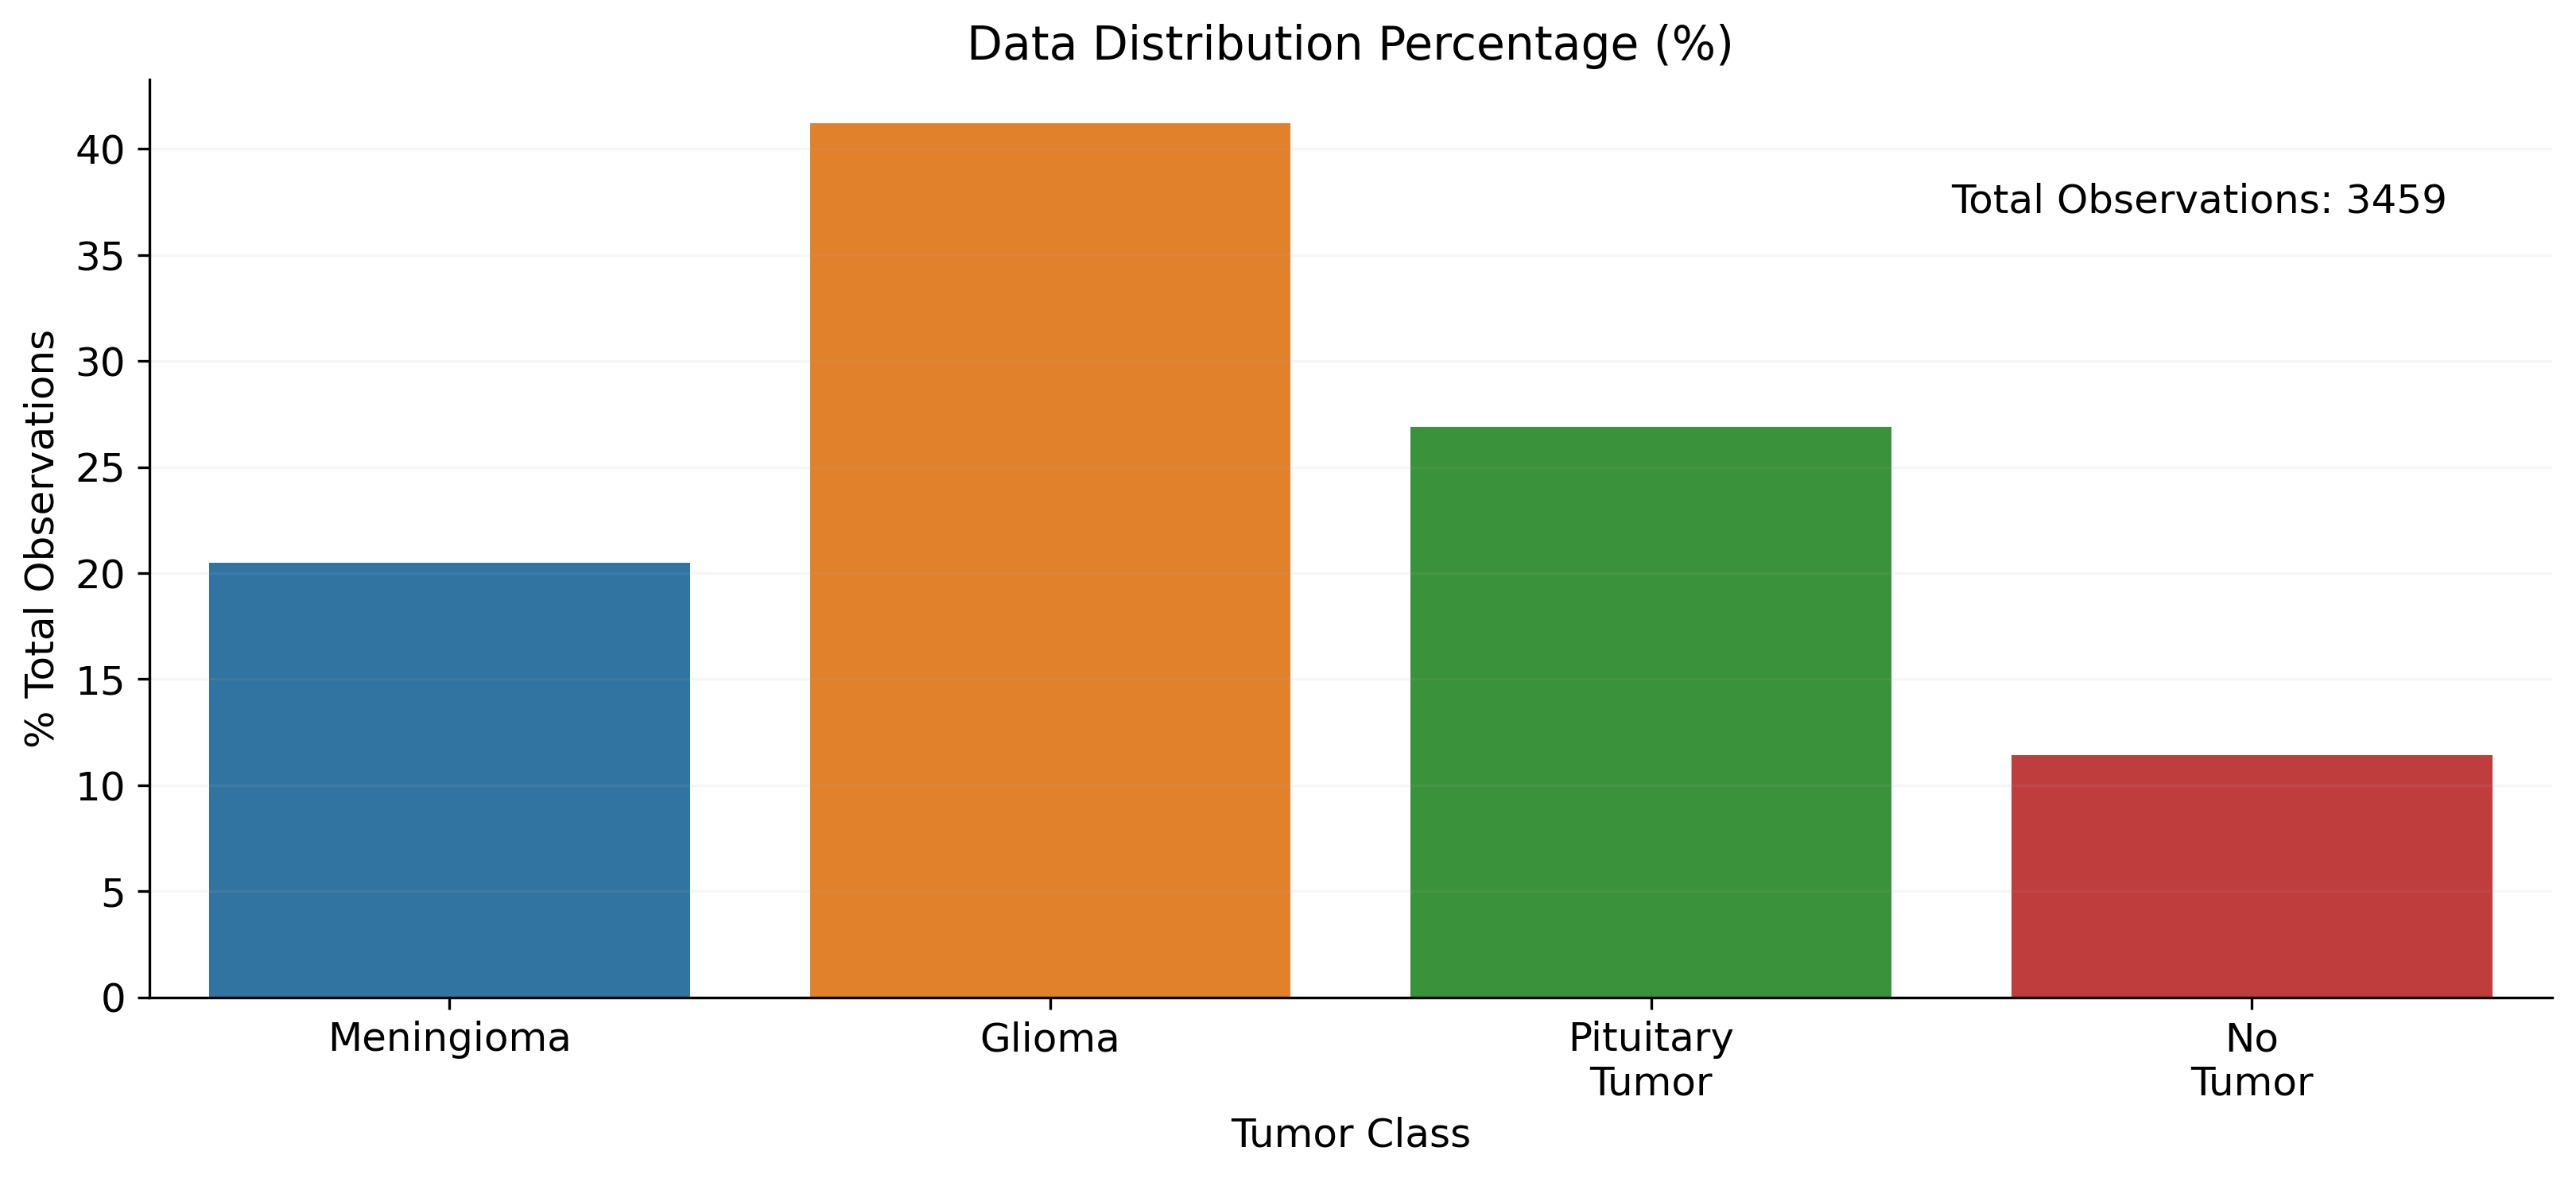

In [70]:
fig, axis = plt.subplots(figsize = (13, 5))
axis.grid(True, alpha = 0.1)
axis.set_title("Data Distribution Percentage (%)", fontsize = 14)
sns.barplot(x = ['\n'.join(curr_index.strip().split('_')).title() for curr_index in data_distribution_count.index], 
            y = 100 * (data_distribution_count / data_distribution_count.sum()), ax = axis)
axis.set_xlabel("Tumor Class", fontsize = 12)
axis.set_ylabel("% Total Observations", fontsize = 12)
axis.tick_params(which = 'major', labelsize = 12)
axis.text(2.5, 37, f'Total Observations: {data_distribution_count.sum()}', fontdict = dict(size = 12))
sns.despine()

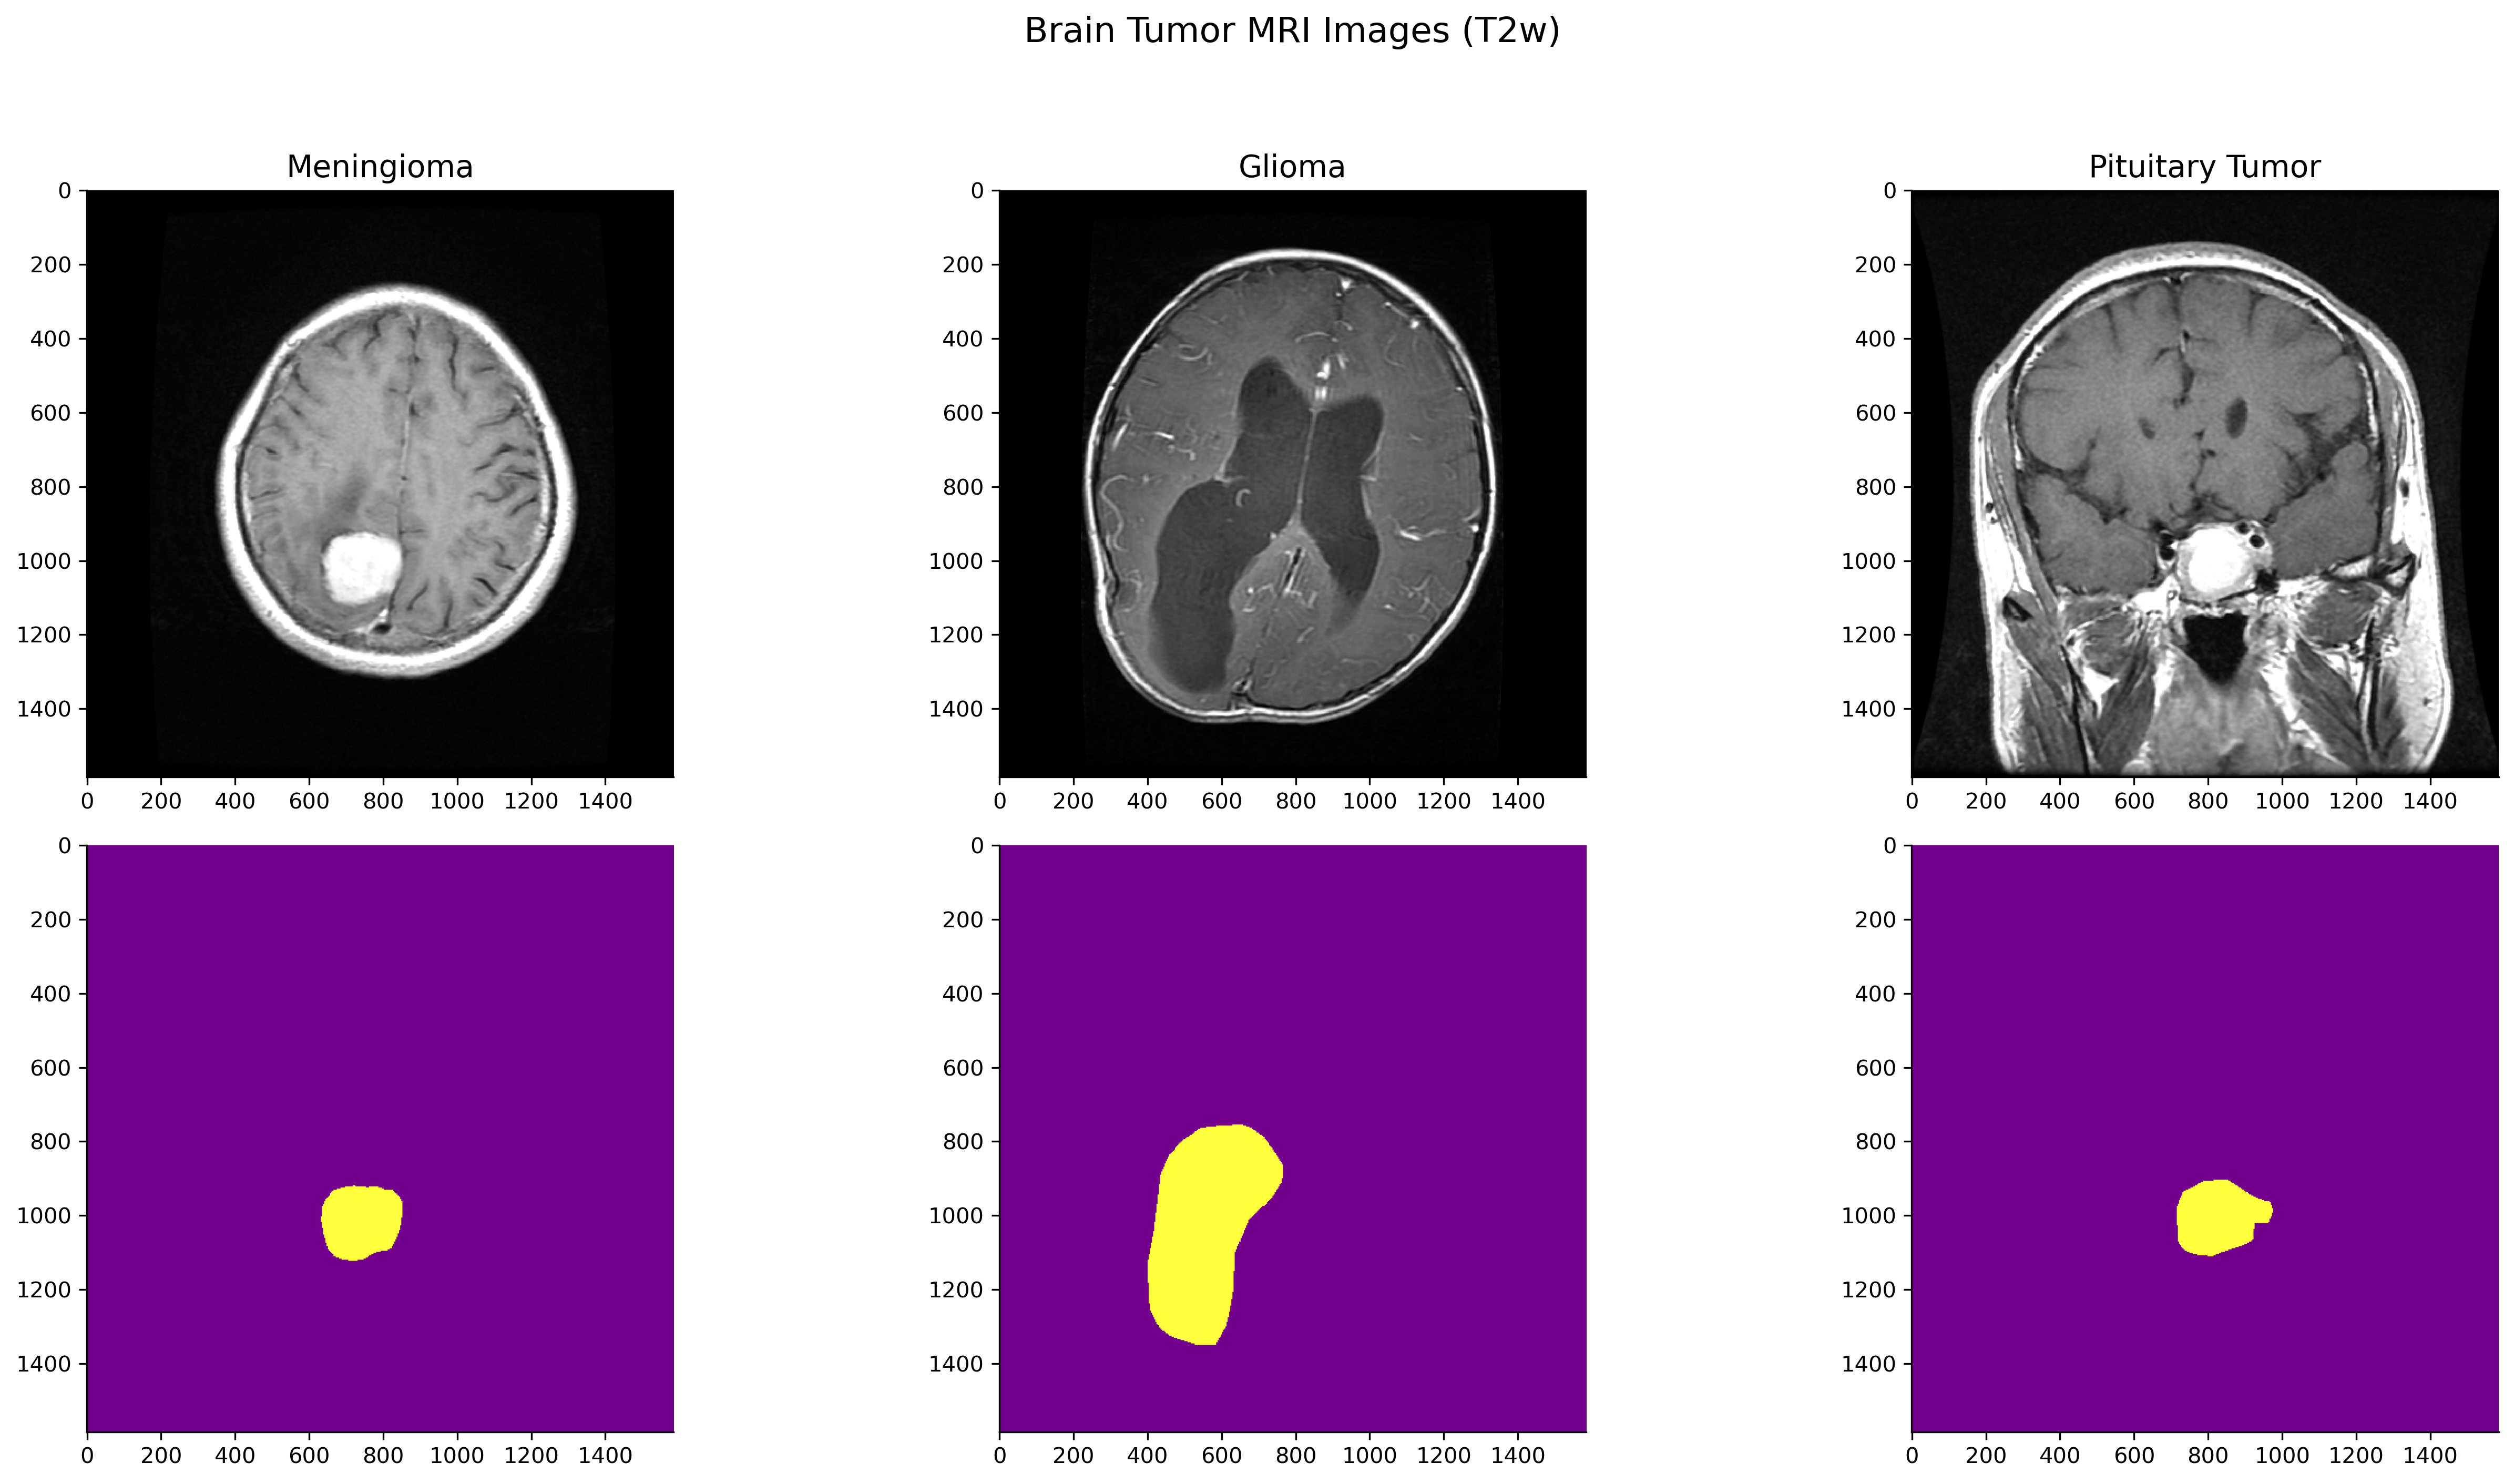

In [71]:
BRIGHTNESS_FACTOR = 1.7
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (18, 9))
axes = axes.flatten()
fig.suptitle("Brain Tumor MRI Images (T2w)", fontsize = 16, fontdict = dict(weight = 'bold'), y = 1.04)
for curr_title, filename, curr_axis in zip(TUMOR_CLASS[:-1], IMAGE_DATA_PATHS[:-1], axes[:3]):
    curr_image = Image.open(os.path.join(filename, os.listdir(filename)[2]))
    img_enhancer = ImageEnhance.Brightness(curr_image)
    curr_axis.imshow(img_enhancer.enhance(BRIGHTNESS_FACTOR))
    curr_axis.set_title(" ".join(curr_title.split('_')).title(), fontsize = 14)
 
for filename, curr_axis in zip(MASK_DATA_PATHS, axes[3:]):
    curr_image = Image.open(os.path.join(filename, os.listdir(filename)[2]))
    mask_enhancer = ImageEnhance.Brightness(curr_image)
    curr_axis.imshow(mask_enhancer.enhance(BRIGHTNESS_FACTOR))
fig.tight_layout()
sns.despine()

In [72]:
image_data_paths = []
for curr_path, tumor_name in zip(IMAGE_DATA_PATHS, TUMOR_CLASS):
    if os.path.exists(curr_path) and os.path.isdir(curr_path):
        image_data_paths.extend(map(lambda filename: (os.path.join(curr_path, filename), tumor_name), os.listdir(curr_path)))

In [73]:
image_data_paths_df = pd.DataFrame(image_data_paths, columns = ['image_filepaths', 'tumor_class']).sample(frac = 1, random_state = 42).reset_index(drop = True)
image_data_paths_df.head()

image_filepaths      tumor_class
0  C:/USERS/HP/BRAIN-MRI-IMAGE-CLASSIFICATION-USI...       meningioma
1  C:/USERS/HP/BRAIN-MRI-IMAGE-CLASSIFICATION-USI...       meningioma
2  C:/USERS/HP/BRAIN-MRI-IMAGE-CLASSIFICATION-USI...  pituitary_tumor
3  C:/USERS/HP/BRAIN-MRI-IMAGE-CLASSIFICATION-USI...  pituitary_tumor
4  C:/USERS/HP/BRAIN-MRI-IMAGE-CLASSIFICATION-USI...  pituitary_tumor

In [74]:
image_data_paths_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3459 entries, 0 to 3458
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   image_filepaths  3459 non-null   object
 1   tumor_class      3459 non-null   object
dtypes: object(2)
memory usage: 54.2+ KB


In [75]:
intermediate_train_data, test_data = train_test_split(image_data_paths_df, 
                                                      train_size = 0.70, 
                                                      random_state = 42, 
                                                      stratify = image_data_paths_df.tumor_class)
 
train_data, validation_data = train_test_split(intermediate_train_data, 
                                               train_size = 0.80, 
                                               random_state = 42, 
                                               stratify = intermediate_train_data.tumor_class)

C:\Users\Hp\AppData\Local\Temp\ipykernel_8780\1910373645.py:7: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  curr_axis.grid(False, alpha = 0.1)


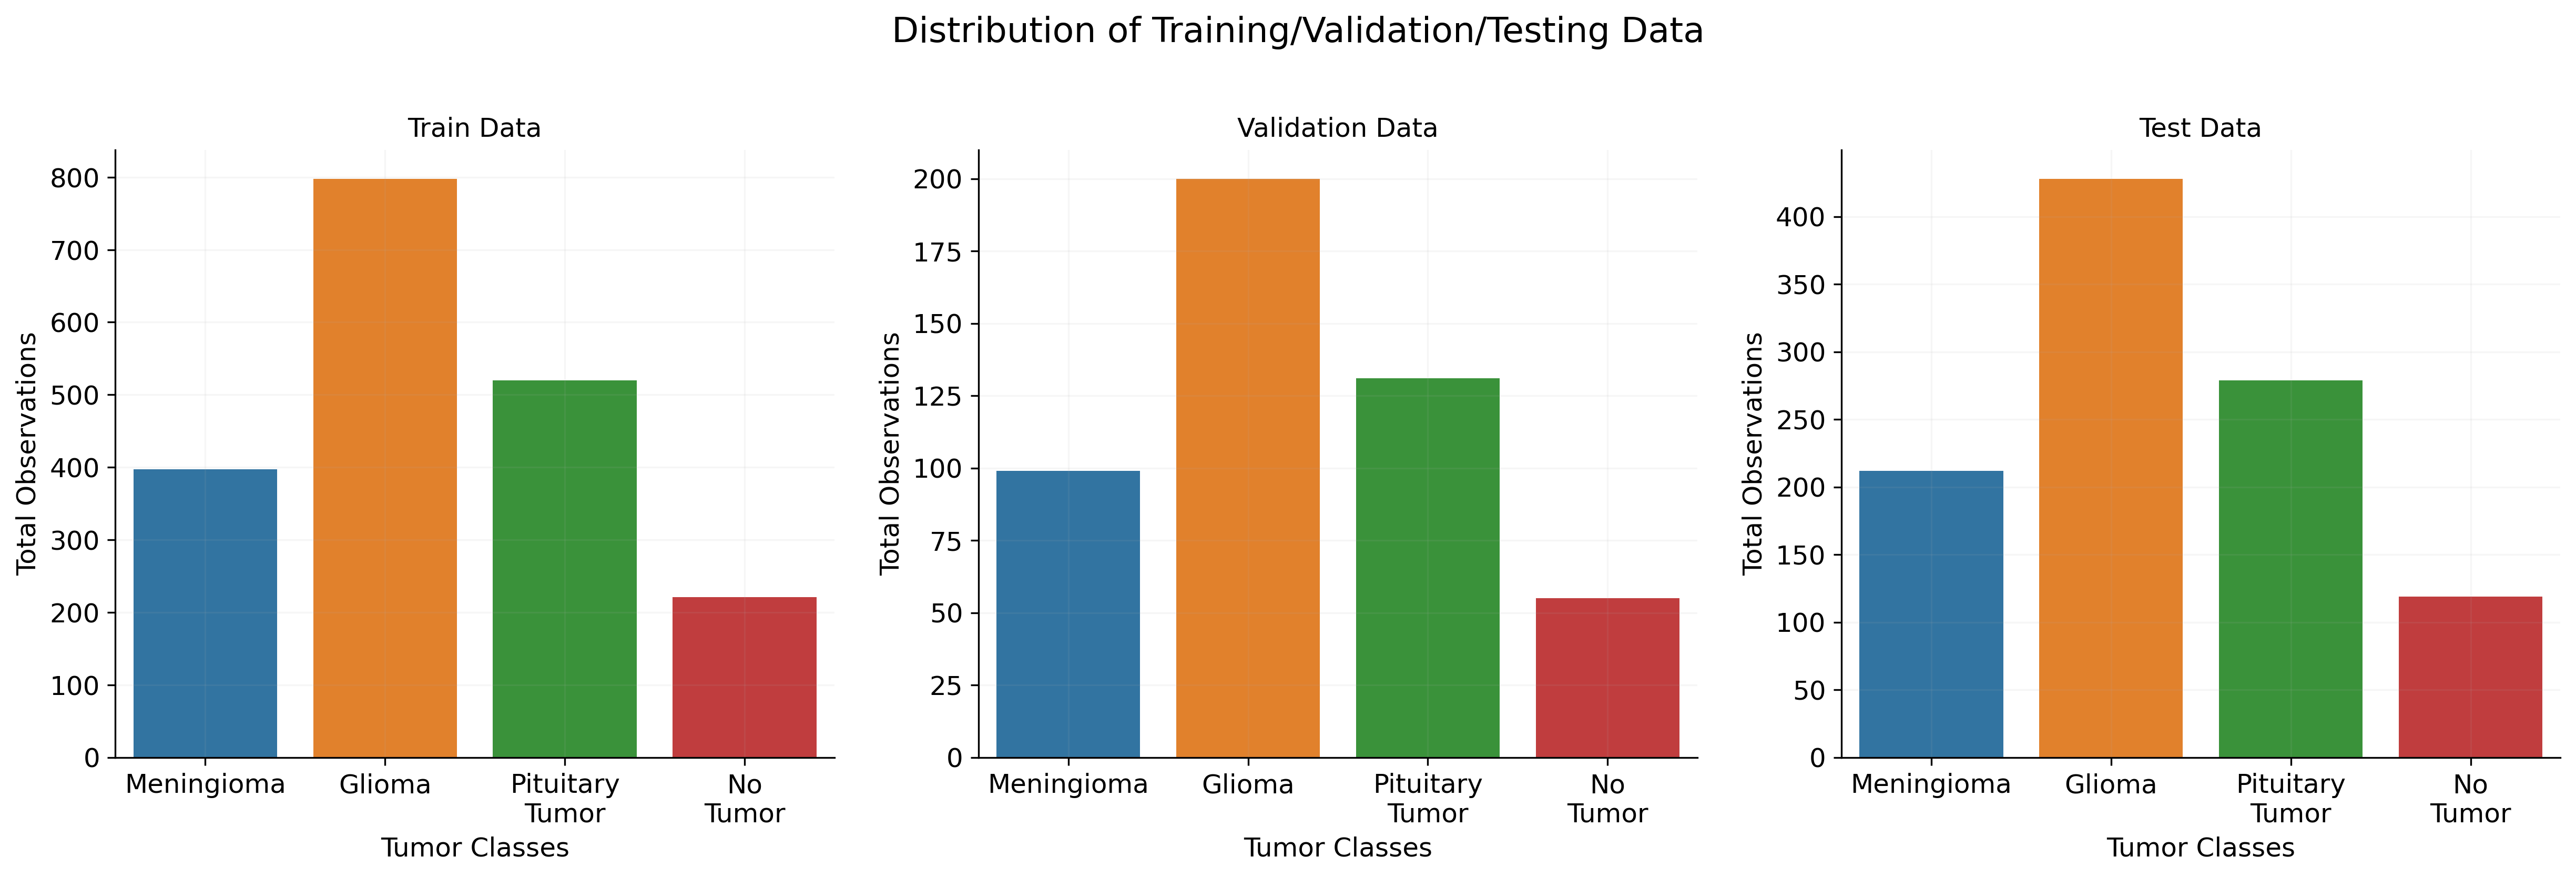

In [76]:
fig, axes = plt.subplots(ncols = 3, figsize = (20, 5))
fig.suptitle("Distribution of Training/Validation/Testing Data", fontsize = 16, fontdict = dict(weight = 'bold'), y = 1.05)
sns.countplot(x = train_data.tumor_class, order = TUMOR_CLASS, ax = axes[0])
sns.countplot(x = validation_data.tumor_class, order = TUMOR_CLASS, ax = axes[1])
sns.countplot(x = test_data.tumor_class, order = TUMOR_CLASS, ax = axes[2])
for curr_axis, curr_title in zip(axes, ['Train Data', 'Validation Data', 'Test Data']):
    curr_axis.grid(False, alpha = 0.1)
    curr_axis.set_title(curr_title, fontsize = 12)
    curr_axis.set_xlabel("Tumor Classes", fontsize = 12)
    curr_axis.set_ylabel("Total Observations", fontsize = 12)
    curr_axis.tick_params(which = 'major', labelsize = 12)
    curr_axis.set_xticklabels(["\n".join(xtick.split("_")).title() for xtick in TUMOR_CLASS])
sns.despine()

In [77]:
image_size = 128
batch_size = 32

image_datagen_kwargs = dict(rescale = 1 / 255,
                            rotation_range = 15, 
                            width_shift_range = 0.1, 
                            zoom_range = 0.01, 
                            shear_range = 0.01,
                            brightness_range = [0.3, 1.5],
                            horizontal_flip = True,
                            vertical_flip = True)

In [78]:
train_image_datagen = ImageDataGenerator(**image_datagen_kwargs)
validation_image_datagen = ImageDataGenerator(**image_datagen_kwargs)
test_image_datagen = ImageDataGenerator(**image_datagen_kwargs)

In [79]:
train_dataset = train_image_datagen.flow_from_dataframe(train_data, 
                                                        x_col = 'image_filepaths', 
                                                        y_col = 'tumor_class', 
                                                        seed = 42, 
                                                        batch_size = batch_size,
                                                        target_size = (image_size, image_size),
                                                        color_mode = 'rgb')
validation_dataset = validation_image_datagen.flow_from_dataframe(validation_data, 
                                                                  x_col = 'image_filepaths', 
                                                                  y_col = 'tumor_class', 
                                                                  seed = 42,
                                                                  batch_size = batch_size, 
                                                                  target_size = (image_size, image_size),
                                                                  color_mode = 'rgb')
test_dataset = test_image_datagen.flow_from_dataframe(test_data, 
                                                      x_col = 'image_filepaths', 
                                                      y_col = 'tumor_class', 
                                                      seed = 42, 
                                                      batch_size = batch_size,
                                                      target_size = (image_size, image_size),
                                                      color_mode = 'rgb')

Found 1936 validated image filenames belonging to 4 classes.
Found 485 validated image filenames belonging to 4 classes.
Found 1038 validated image filenames belonging to 4 classes.


In [80]:
print("Information about Training Dataset:")
print(train_dataset.class_indices)
print(train_dataset.image_shape, end = '\n\n')
 
print("Information about Validation Dataset:")
print(validation_dataset.class_indices)
print(validation_dataset.image_shape, end = '\n\n')
 
print("Information about Testing Dataset:")
print(test_dataset.class_indices)
print(test_dataset.image_shape)

Information about Training Dataset:
{'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
(128, 128, 3)

Information about Validation Dataset:
{'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
(128, 128, 3)

Information about Testing Dataset:
{'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
(128, 128, 3)


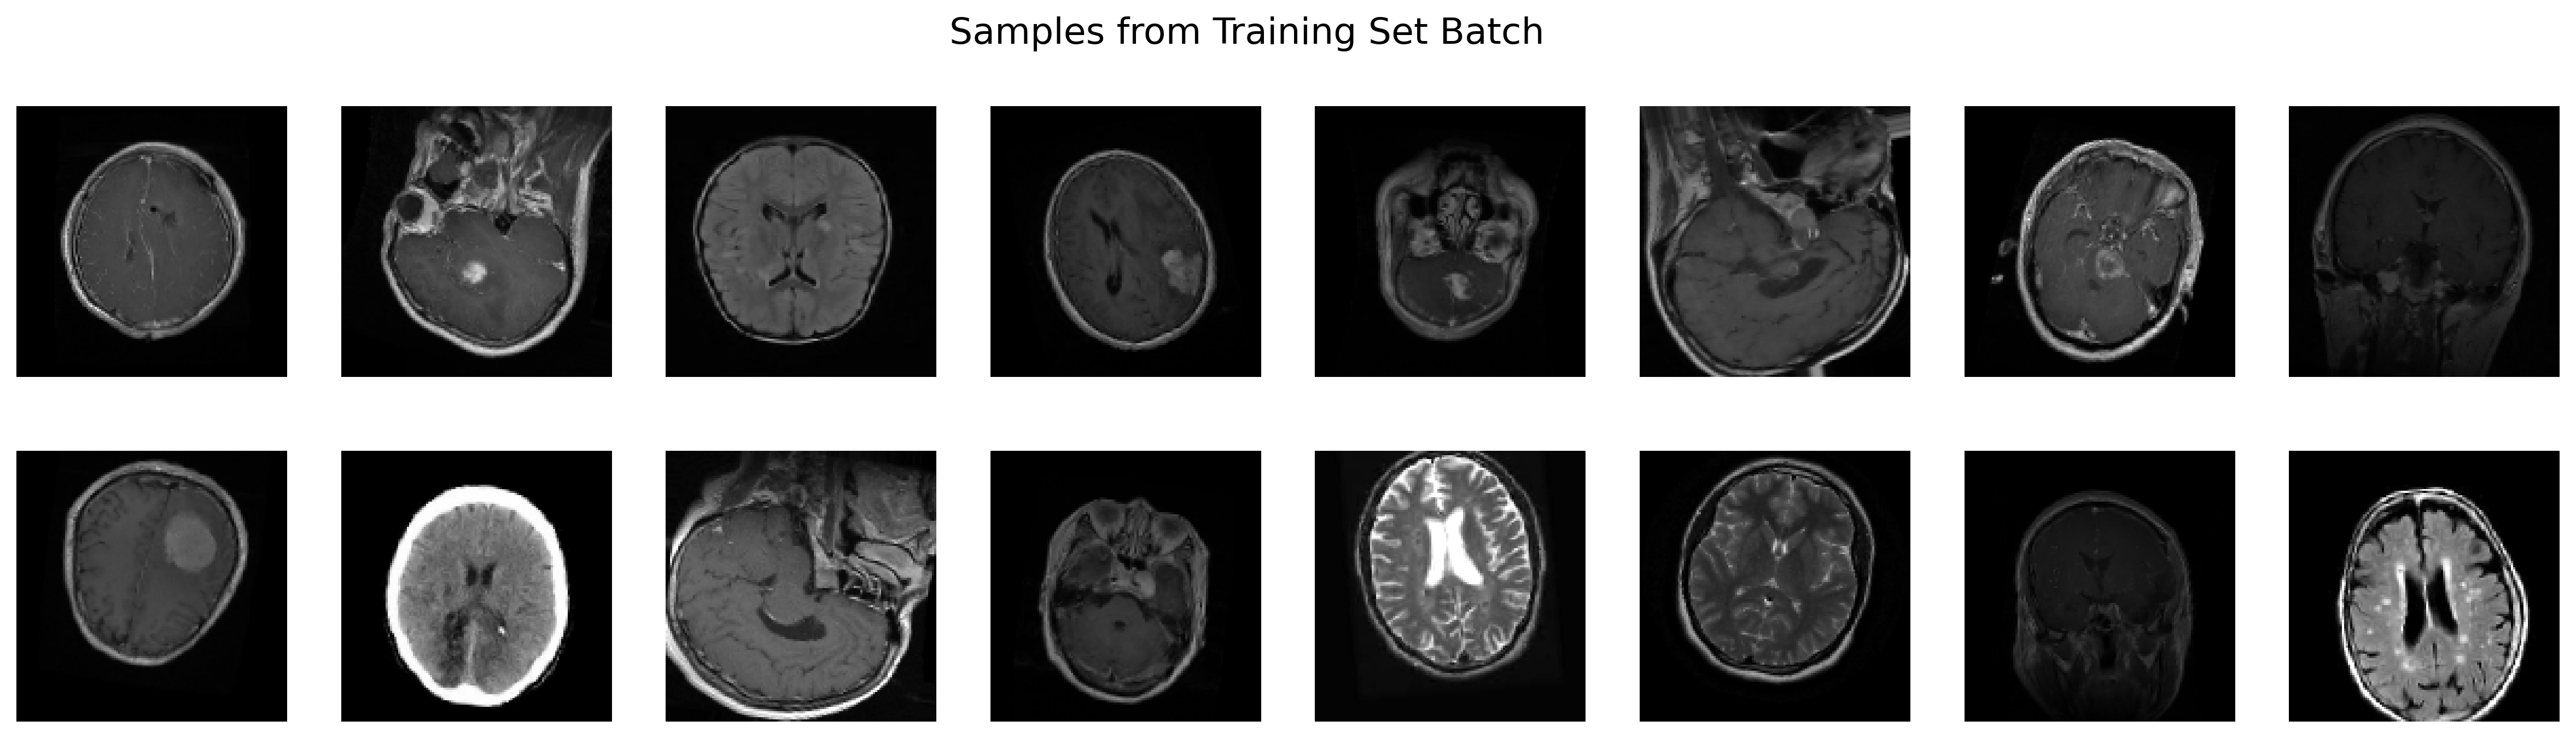

In [81]:
fig, axes = plt.subplots(nrows = 2, ncols = 8, figsize = (20, 5))
fig.suptitle("Samples from Training Set Batch", fontsize = 16, fontdict = dict(weight = 'bold'))
for curr_axis, curr_image in zip(axes.flatten(), train_dataset[0][0][:16]):
    curr_axis.imshow(tf.squeeze(curr_image), cmap = 'gray')
    curr_axis.axis(False)

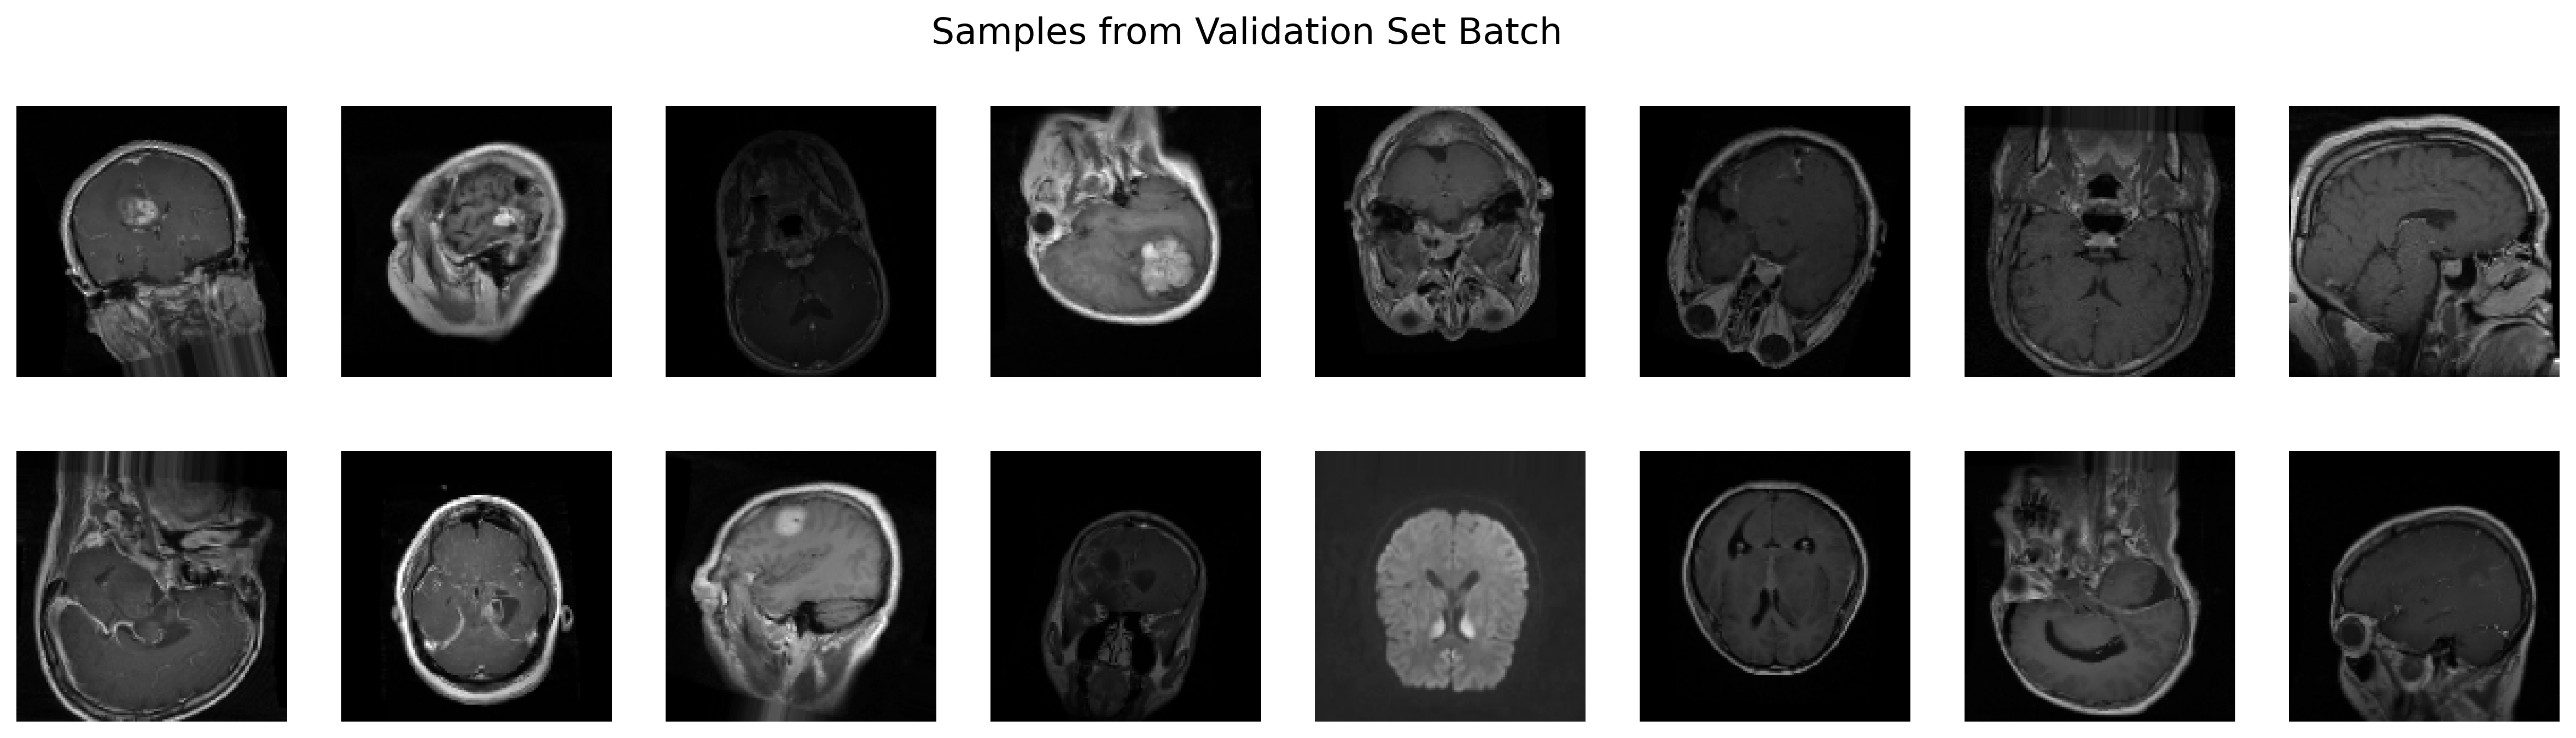

In [82]:
fig, axes = plt.subplots(nrows = 2, ncols = 8, figsize = (20, 5))
fig.suptitle("Samples from Validation Set Batch", fontsize = 16, fontdict = dict(weight = 'bold'))
for curr_axis, curr_image in zip(axes.flatten(), validation_dataset[0][0][:16]):
    curr_axis.imshow(tf.squeeze(curr_image), cmap = 'gray')
    curr_axis.axis(False)

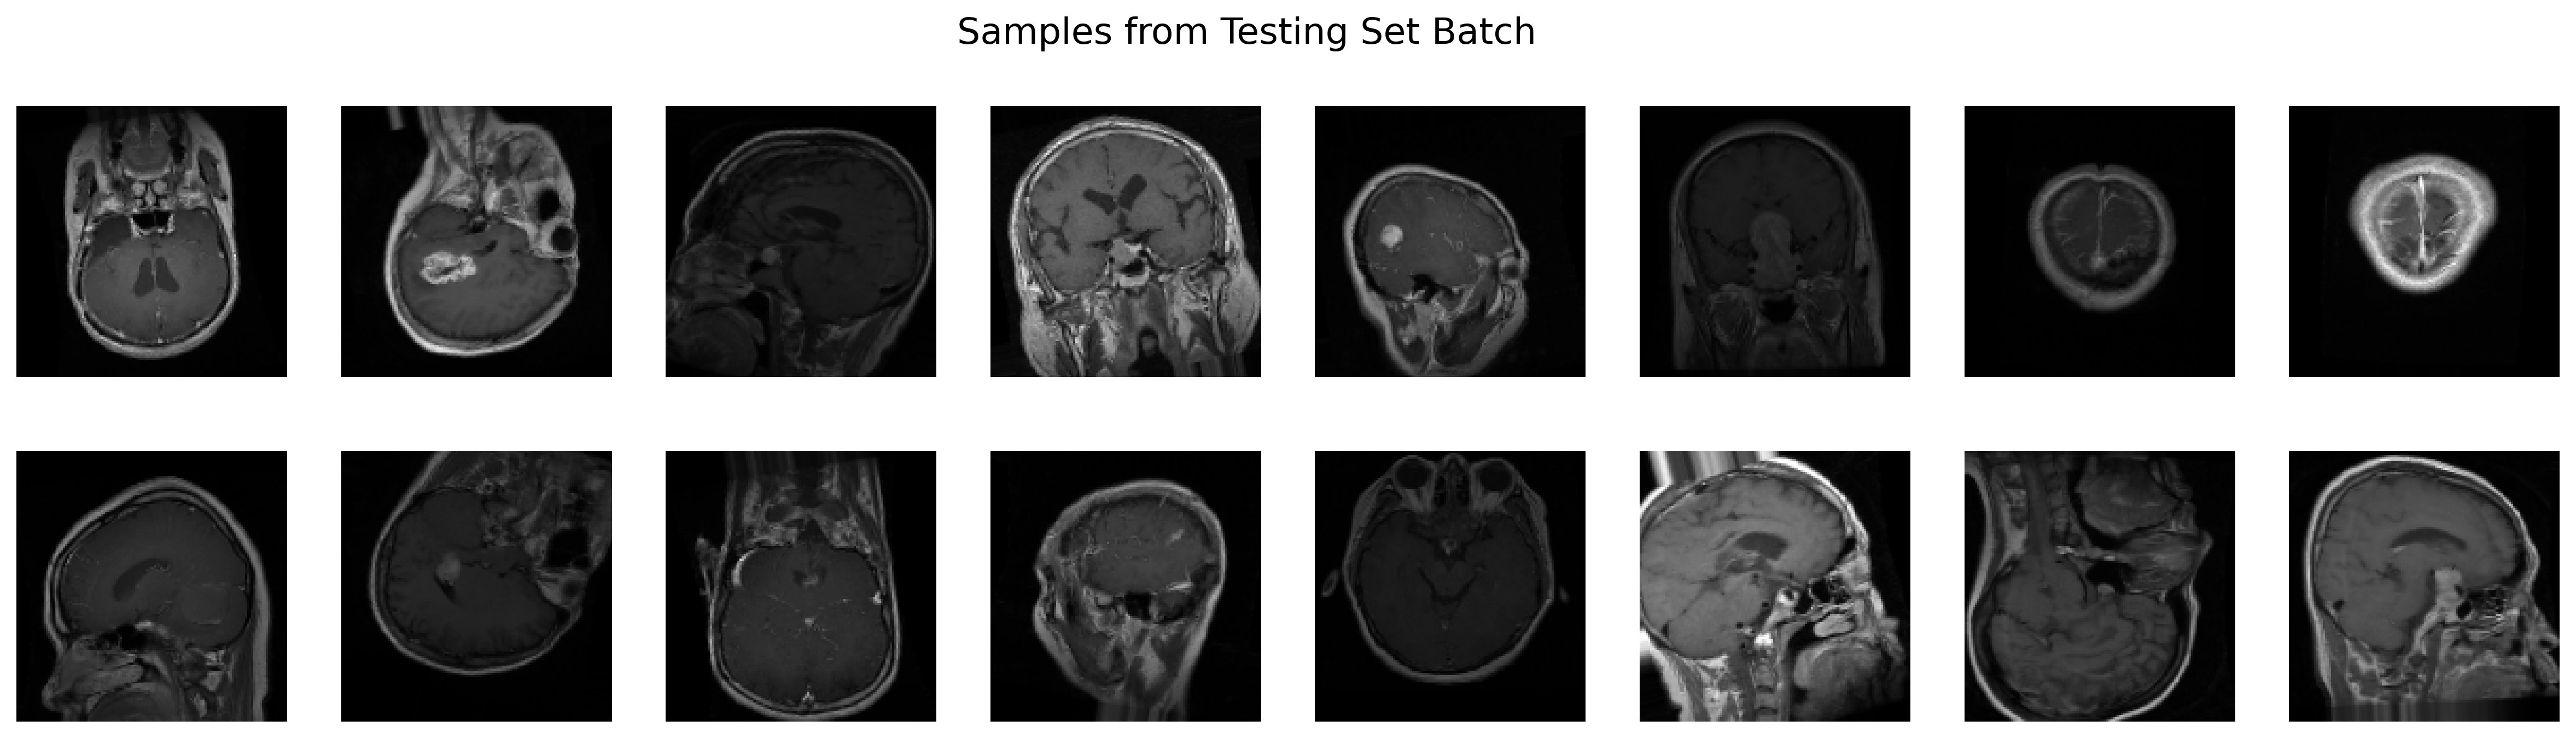

In [83]:
fig, axes = plt.subplots(nrows = 2, ncols = 8, figsize = (20, 5))
fig.suptitle("Samples from Testing Set Batch", fontsize = 16, fontdict = dict(weight = 'bold'))
for curr_axis, curr_image in zip(axes.flatten(), test_dataset[0][0][:16]):
    curr_axis.imshow(tf.squeeze(curr_image), cmap = 'gray')
    curr_axis.axis(False)

In [84]:
early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 10)

In [85]:
os.makedirs(MLP_CHECKPOINT_DIR_PATH, exist_ok=True)
os.makedirs(ALEXNET_CHECKPOINT_DIR_PATH, exist_ok=True)
os.makedirs(INCEPTIONV3_CHECKPOINT_DIR_PATH, exist_ok=True)


In [86]:
ROOT_CHECKPOINT_DIR_PATH = os.path.join(ROOT_DIR, "Model-Checkpoints")
MLP_CHECKPOINT_DIR_PATH = os.path.join(ROOT_CHECKPOINT_DIR_PATH, "Multi-Layer-Perceptron")
ALEXNET_CHECKPOINT_DIR_PATH = os.path.join(ROOT_CHECKPOINT_DIR_PATH, "AlexNet-CNN")
INCEPTIONV3_CHECKPOINT_DIR_PATH = os.path.join(ROOT_CHECKPOINT_DIR_PATH, "InceptionV3")
assert os.path.isdir(ROOT_CHECKPOINT_DIR_PATH) and os.path.isdir(MLP_CHECKPOINT_DIR_PATH) and os.path.isdir(ALEXNET_CHECKPOINT_DIR_PATH) and os.path.isdir(INCEPTIONV3_CHECKPOINT_DIR_PATH)

In [87]:
mlp_cp_callback = ModelCheckpoint(MLP_CHECKPOINT_DIR_PATH, 
                                  monitor = 'val_accuracy', 
                                  verbose = 1, 
                                  save_weights_only = True, 
                                  save_freq =  'epoch')

alexnet_cp_callback = ModelCheckpoint(ALEXNET_CHECKPOINT_DIR_PATH, 
                                      monitor = 'val_accuracy', 
                                      verbose = 1, 
                                      save_weights_only = True, 
                                      save_freq = 'epoch')

inceptionv3_cp_callback = ModelCheckpoint(INCEPTIONV3_CHECKPOINT_DIR_PATH, 
                                          monitor = 'val_accuracy', 
                                          verbose = 1, 
                                          save_weights_only = True, 
                                          save_freq = 'epoch')

In [88]:
def training_process_viz(training_stats: pd.DataFrame, **plot_kwargs) -> None:
    fig, axes = plt.subplots(ncols = 2, figsize = (15, 5))
    fig.suptitle(plot_kwargs['plot_title'], fontsize = 16, fontdict = dict(weight = 'bold'), y = 1.08)
    for curr_axis, col_name in zip(axes, ['accuracy', 'loss']):
        curr_axis.grid(True, alpha = 0.3)
        curr_axis.set_title(f"Model {col_name}".title(), fontsize = 14)
        sns.lineplot(x = range(1, 1 + training_stats.shape[0]), y = training_stats[col_name], color = 'blue', ax = curr_axis)
        sns.lineplot(x = range(1, 1 + training_stats.shape[0]), y = training_stats[f"val_{col_name}"], color = 'red', ax = curr_axis)
        curr_axis.set_xlabel("Epochs", fontsize = 12)
        curr_axis.set_ylabel(col_name.title(), fontsize = 12)
        curr_axis.tick_params(which = 'major', labelsize = 12)
        curr_axis.legend([col_name.title(), f"validation {col_name}".title()], title = col_name.title())
    fig.tight_layout()
    sns.despine()

In [110]:
def confusion_matrix_viz(model, test_dataset, **plot_kwargs) -> None:
    assert isinstance(model, Sequential)
    model_preds = [np.argmax(curr_row) for curr_row in model.predict(test_dataset)]
    fig, axis = plt.subplots(figsize = (8, 6))
    class_names = ['Glioma', 'Meningioma', 'No-Tumor', 'Pituitary\nTumor']
    sns.heatmap(confusion_matrix(test_dataset.classes, model_preds), annot = True, cmap = plt.cm.Reds, ax = axis)
    axis.set_title(plot_kwargs['plot_title'], fontsize = 14)
    axis.tick_params(which = 'major', labelsize = 12)
    axis.set_xlabel("Predicted Class", fontsize = 12)
    axis.set_ylabel("Actual Class", fontsize = 12)
    axis.set_xticklabels(class_names, fontdict = dict(fontsize = 12))
    axis.set_yticklabels(class_names, fontdict = dict(fontsize = 12))
    fig.tight_layout()
    sns.despine()

In [90]:
def generate_report(*models, test_dataset, row_indexes) -> pd.DataFrame:
    assert len(models)
    report_df = pd.DataFrame(columns = ['MAE', 'MSE', 'RMSE', 'Loss', 'Accuracy', 'F1-Score'])
    y_hat = test_dataset.classes # y_hat = ground_truth
    for curr_index, curr_model in enumerate(models):
        assert isinstance(curr_model, Sequential)
        curr_model_loss, curr_model_accuracy = curr_model.evaluate(test_dataset)
        y_preds = [np.argmax(curr_preds) for curr_preds in curr_model.predict(test_dataset)]
        report_df.loc[curr_index] = [mean_absolute_error(y_hat, y_preds), mean_squared_error(y_hat, y_preds), mean_squared_error(y_hat, y_preds, squared = False), curr_model_loss, curr_model_accuracy, f1_score(y_hat, y_preds, average = "micro")]
    report_df.index = row_indexes
    return report_df

In [91]:
mlp_model = Sequential()
mlp_model.add(Flatten(input_shape = (image_size, image_size, 3), name = 'Flatten-Layer'))
mlp_model.add(Dense(2048, activation = 'relu', name = 'Hidden-Layer-1'))
mlp_model.add(Dropout(rate = 0.2, name = 'Dropout-Layer-1'))
mlp_model.add(Dense(1024, activation = 'relu', name = 'Hidden-Layer-2'))
mlp_model.add(Dropout(rate = 0.2, name = 'Dropout-Layer-2'))
mlp_model.add(Dense(512, activation = 'relu', name = 'Hidden-Layer-3'))
mlp_model.add(Dropout(rate = 0.2, name = 'Dropout-Layer-3'))
mlp_model.add(Dense(4, activation = 'softmax', name = 'Output-Layer-1'))
mlp_model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
mlp_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Flatten-Layer (Flatten)     (None, 49152)             0         
                                                                 
 Hidden-Layer-1 (Dense)      (None, 2048)              100665344 
                                                                 
 Dropout-Layer-1 (Dropout)   (None, 2048)              0         
                                                                 
 Hidden-Layer-2 (Dense)      (None, 1024)              2098176   
                                                                 
 Dropout-Layer-2 (Dropout)   (None, 1024)              0         
                                                                 
 Hidden-Layer-3 (Dense)      (None, 512)               524800    
                                                                 
 Dropout-Layer-3 (Dropout)   (None, 512)              

In [101]:
with tf.device(gpu_device_location) if gpu_device_location else tpu_strategy.scope() if tpu_device_location else tf.device(cpu_device_location):
    mlp_train_history = mlp_model.fit(train_dataset,
                                      batch_size = batch_size,
                                      validation_data = validation_dataset,
                                      epochs = 100, 
                                      callbacks = [early_stopping])

Epoch 1/100
61/61 [==============================] - 159s 3s/step - loss: 1.1395 - accuracy: 0.5491 - val_loss: 1.0923 - val_accuracy: 0.6021
Epoch 2/100
61/61 [==============================] - 155s 3s/step - loss: 1.1150 - accuracy: 0.5651 - val_loss: 1.1293 - val_accuracy: 0.5814
Epoch 3/100
61/61 [==============================] - 162s 3s/step - loss: 1.1114 - accuracy: 0.5553 - val_loss: 1.0746 - val_accuracy: 0.5876
Epoch 4/100
61/61 [==============================] - 152s 2s/step - loss: 1.0887 - accuracy: 0.5640 - val_loss: 1.0656 - val_accuracy: 0.5959
Epoch 5/100
61/61 [==============================] - 165s 3s/step - loss: 1.0572 - accuracy: 0.5754 - val_loss: 1.0774 - val_accuracy: 0.5856
Epoch 6/100
61/61 [==============================] - 152s 2s/step - loss: 1.0669 - accuracy: 0.5775 - val_loss: 1.0366 - val_accuracy: 0.6000
Epoch 7/100
61/61 [==============================] - 143s 2s/step - loss: 1.0596 - accuracy: 0.5857 - val_loss: 1.0208 - val_accuracy: 0.6186
Epoch 

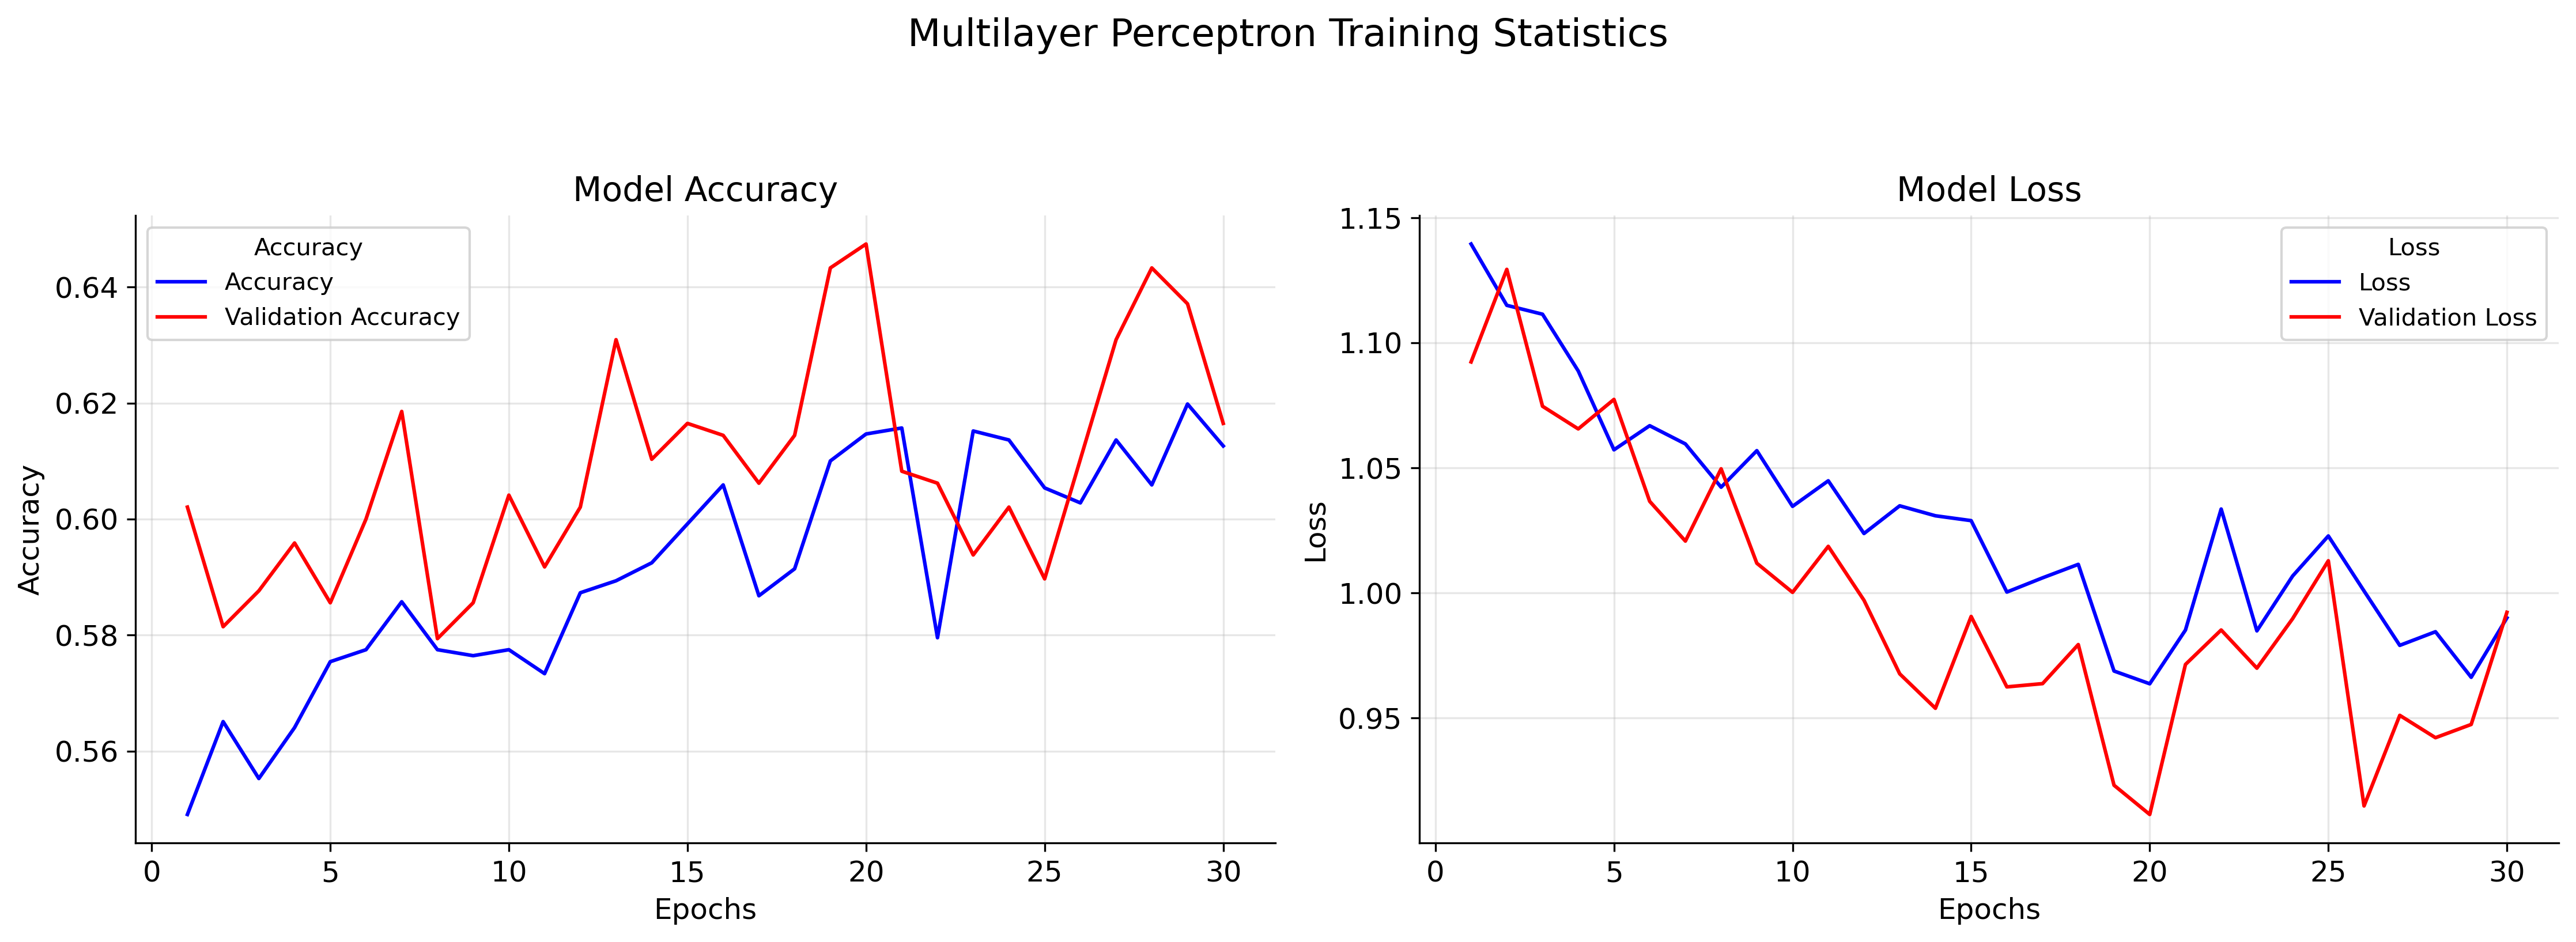

In [102]:
training_process_viz(pd.DataFrame(mlp_train_history.history), 
                     plot_title = 'Multilayer Perceptron Training Statistics')

61/61 [==============================] - 58s 940ms/step


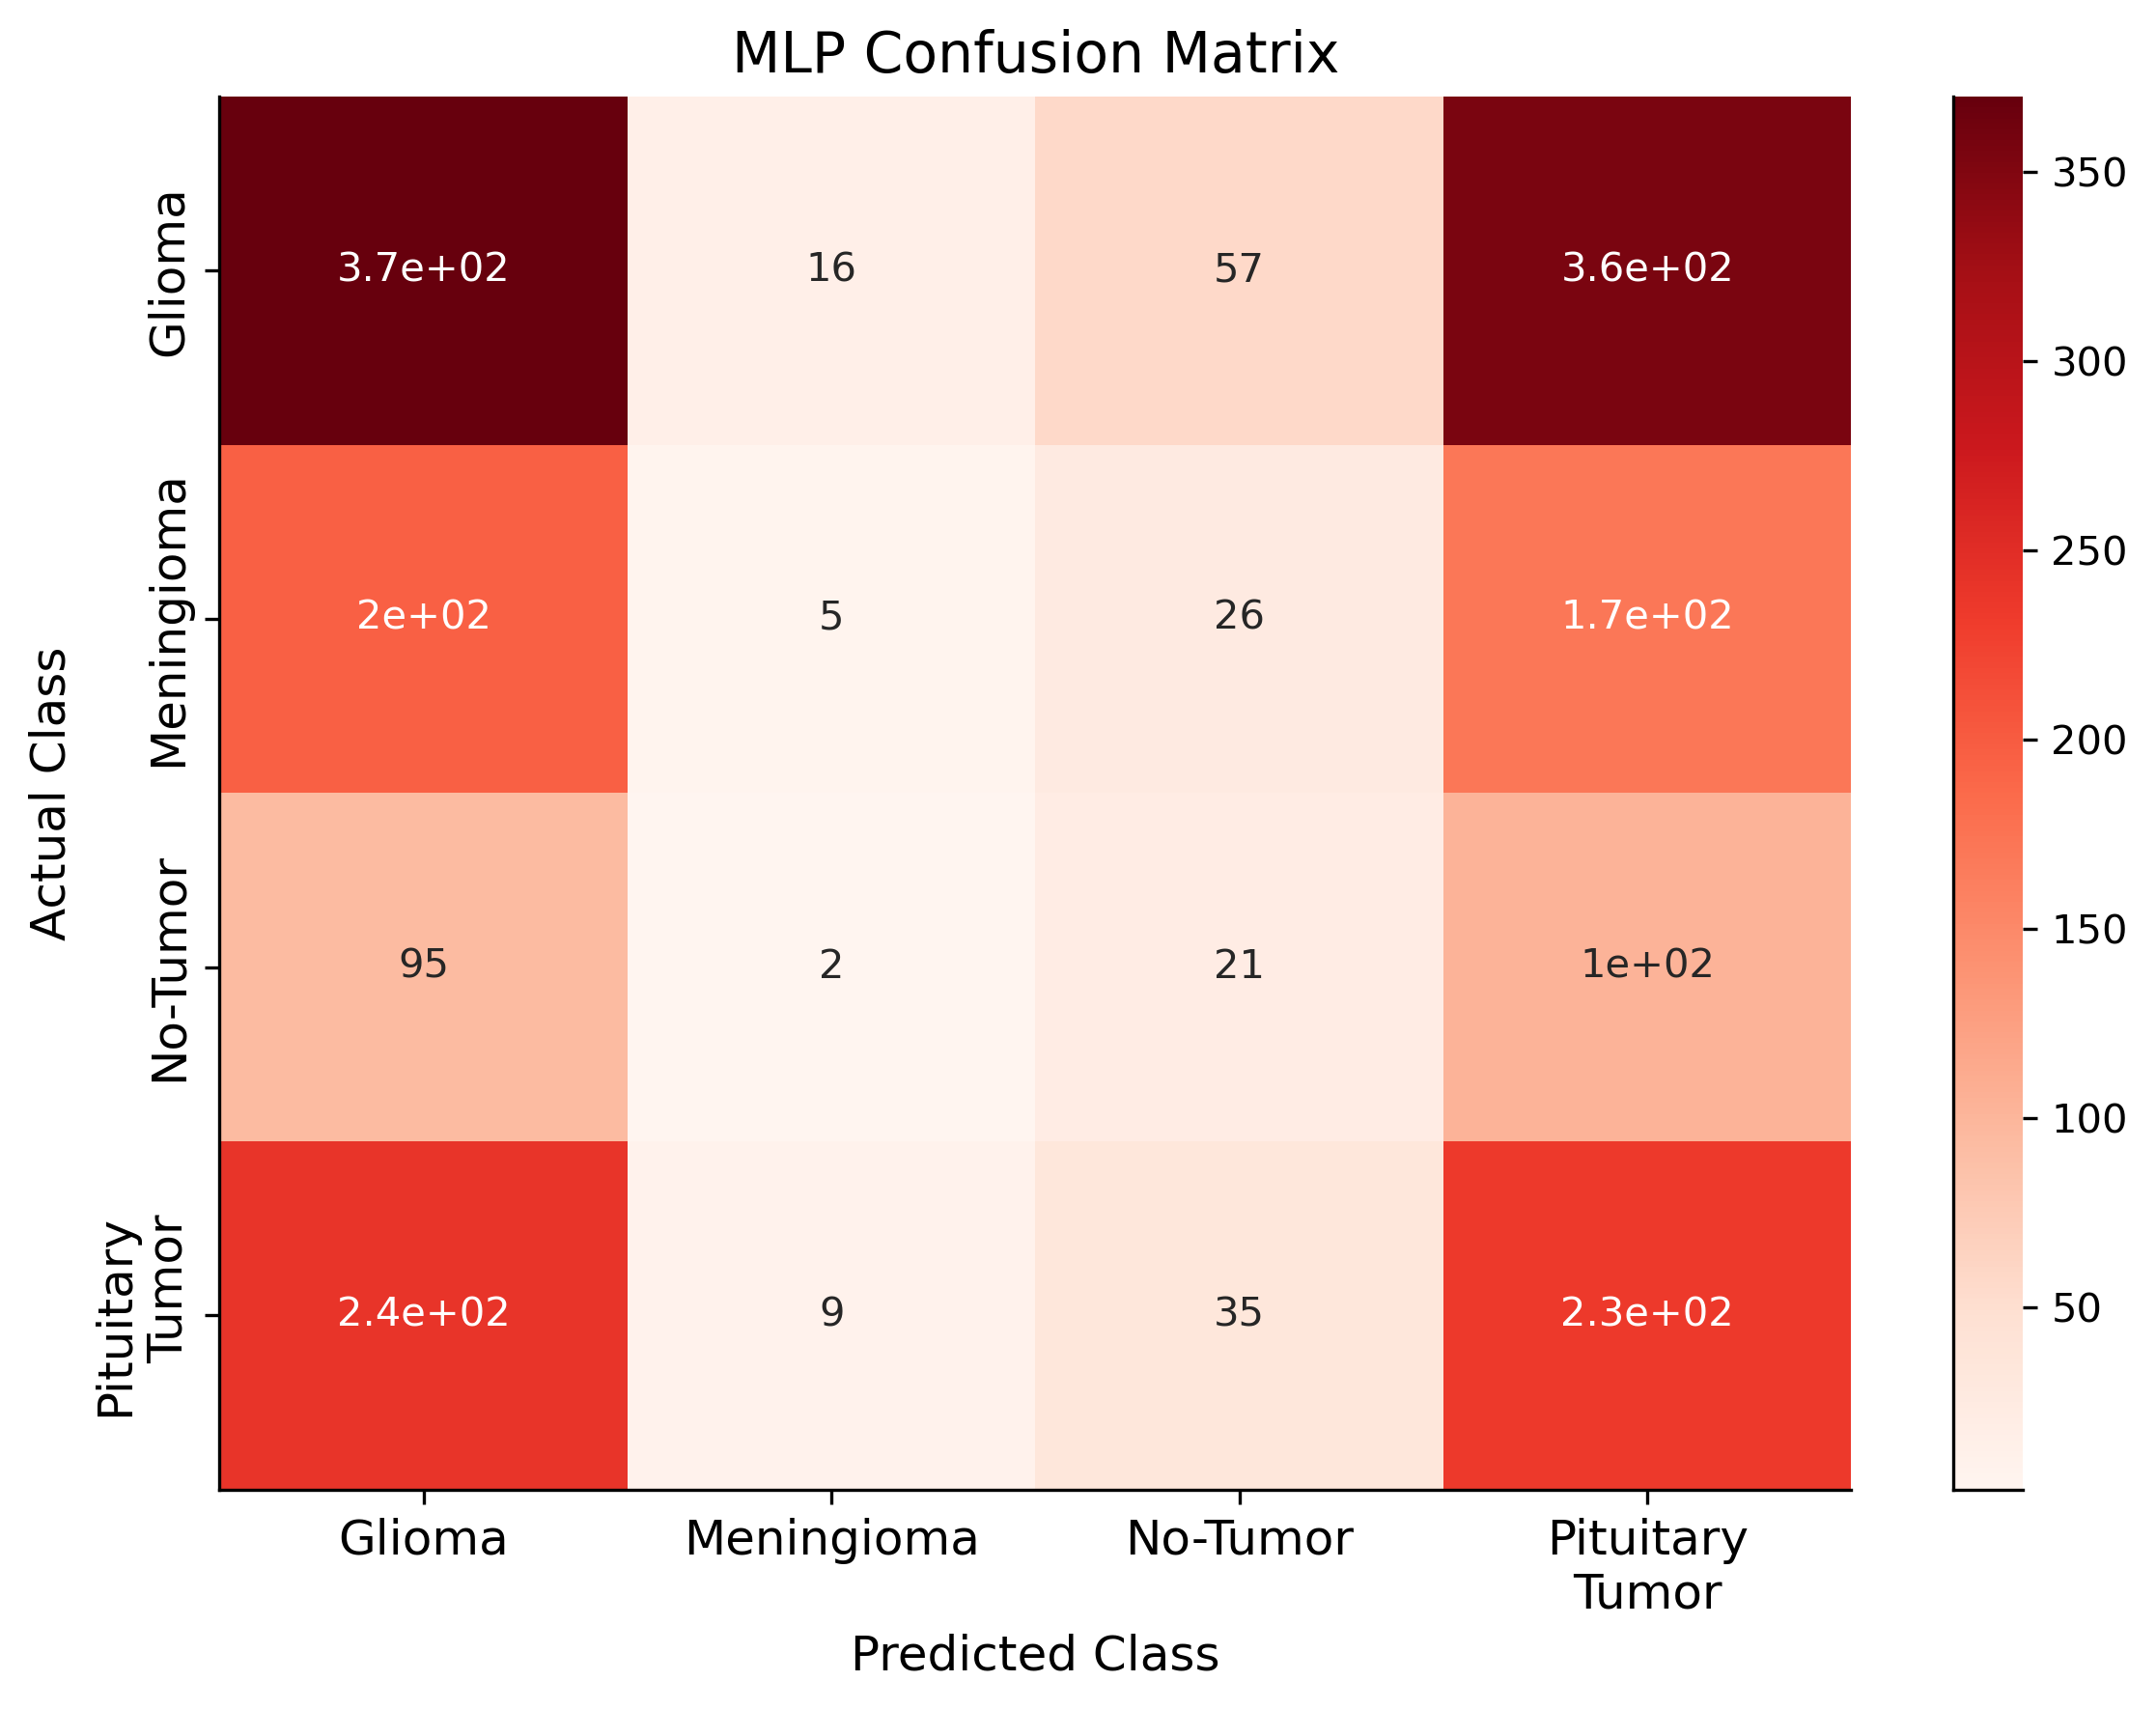

In [111]:
confusion_matrix_viz(mlp_model, train_dataset, plot_title = "MLP Confusion Matrix")

In [104]:
mlp_report_df = generate_report(mlp_model, 
                                test_dataset = test_dataset, 
                                row_indexes = ("Multi-Layer-Perceptron Model",))
mlp_report_df

33/33 [==============================] - 39s 1s/step


MAE       MSE      RMSE      Loss  \
Multi-Layer-Perceptron Model  1.461464  3.671484  1.916112  0.981677   

                              Accuracy  F1-Score  
Multi-Layer-Perceptron Model  0.587669   0.32948

In [105]:
alexnet_cnn = Sequential()
alexnet_cnn.add(Conv2D(96, kernel_size = 11, strides = 4, activation = 'relu', input_shape = (image_size, image_size, 3), name = 'Conv2D-1'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-1'))
alexnet_cnn.add(MaxPool2D(pool_size = 3, strides = 2, name = 'Max-Pooling-1'))
alexnet_cnn.add(Conv2D(256, kernel_size = 5, padding = 'same', activation = 'relu', name = 'Conv2D-2'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-2'))
alexnet_cnn.add(MaxPool2D(pool_size = 3, strides = 2, name = 'Max-Pooling-2'))
alexnet_cnn.add(Conv2D(384, kernel_size = 3, padding = 'same', activation = 'relu', name = 'Conv2D-3'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-3'))
alexnet_cnn.add(Conv2D(384, kernel_size = 3, padding = 'same', activation = 'relu', name = 'Conv2D-4'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-4'))
alexnet_cnn.add(Conv2D(256, kernel_size = 3, padding = 'same', activation = 'relu', name = 'Conv2D-5'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-5'))
alexnet_cnn.add(MaxPool2D(pool_size = 3, strides = 2, name = 'Max-Pooling-3'))
alexnet_cnn.add(Flatten(name = 'Flatten-Layer-1'))
alexnet_cnn.add(Dense(128, activation = 'relu', name = 'Hidden-Layer-1'))
alexnet_cnn.add(Dropout(rate = 0.5, name = 'Dropout-Layer-1'))
alexnet_cnn.add(Dense(64, activation = 'relu', name = 'Hidden-Layer-2'))
alexnet_cnn.add(Dropout(rate = 0.5, name = 'Dropout-Layer-2'))
alexnet_cnn.add(Dense(4, activation = 'softmax', name = 'Output-Layer'))
alexnet_cnn.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
alexnet_cnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D-1 (Conv2D)           (None, 30, 30, 96)        34944     
                                                                 
 Batch-Normalization-1 (Batc  (None, 30, 30, 96)       384       
 hNormalization)                                                 
                                                                 
 Max-Pooling-1 (MaxPooling2D  (None, 14, 14, 96)       0         
 )                                                               
                                                                 
 Conv2D-2 (Conv2D)           (None, 14, 14, 256)       614656    
                                                                 
 Batch-Normalization-2 (Batc  (None, 14, 14, 256)      1024      
 hNormalization)                                                 
                                                      

In [106]:
with tf.device(gpu_device_location) if gpu_device_location else tpu_strategy.scope() if tpu_device_location else tf.device(cpu_device_location):
    alexnet_train_history = alexnet_cnn.fit(train_dataset, 
                                            batch_size = batch_size,
                                            validation_data = validation_dataset, 
                                            epochs = 100, 
                                            callbacks = [early_stopping, alexnet_cp_callback])

Epoch 1/100
61/61 [==============================] - ETA: 0s - loss: 1.8481 - accuracy: 0.3786
Epoch 1: saving model to C:/USERS/HP/BRAIN-MRI-IMAGE-CLASSIFICATION-USING-DEEP-LEARNING\Model-Checkpoints\AlexNet-CNN
61/61 [==============================] - 97s 2s/step - loss: 1.8481 - accuracy: 0.3786 - val_loss: 1.5624 - val_accuracy: 0.3196
Epoch 2/100
61/61 [==============================] - ETA: 0s - loss: 1.2997 - accuracy: 0.4607
Epoch 2: saving model to C:/USERS/HP/BRAIN-MRI-IMAGE-CLASSIFICATION-USING-DEEP-LEARNING\Model-Checkpoints\AlexNet-CNN
61/61 [==============================] - 94s 2s/step - loss: 1.2997 - accuracy: 0.4607 - val_loss: 1.6677 - val_accuracy: 0.3113
Epoch 3/100
61/61 [==============================] - ETA: 0s - loss: 1.2323 - accuracy: 0.4923
Epoch 3: saving model to C:/USERS/HP/BRAIN-MRI-IMAGE-CLASSIFICATION-USING-DEEP-LEARNING\Model-Checkpoints\AlexNet-CNN
61/61 [==============================] - 88s 1s/step - loss: 1.2323 - accuracy: 0.4923 - val_loss: 1.52

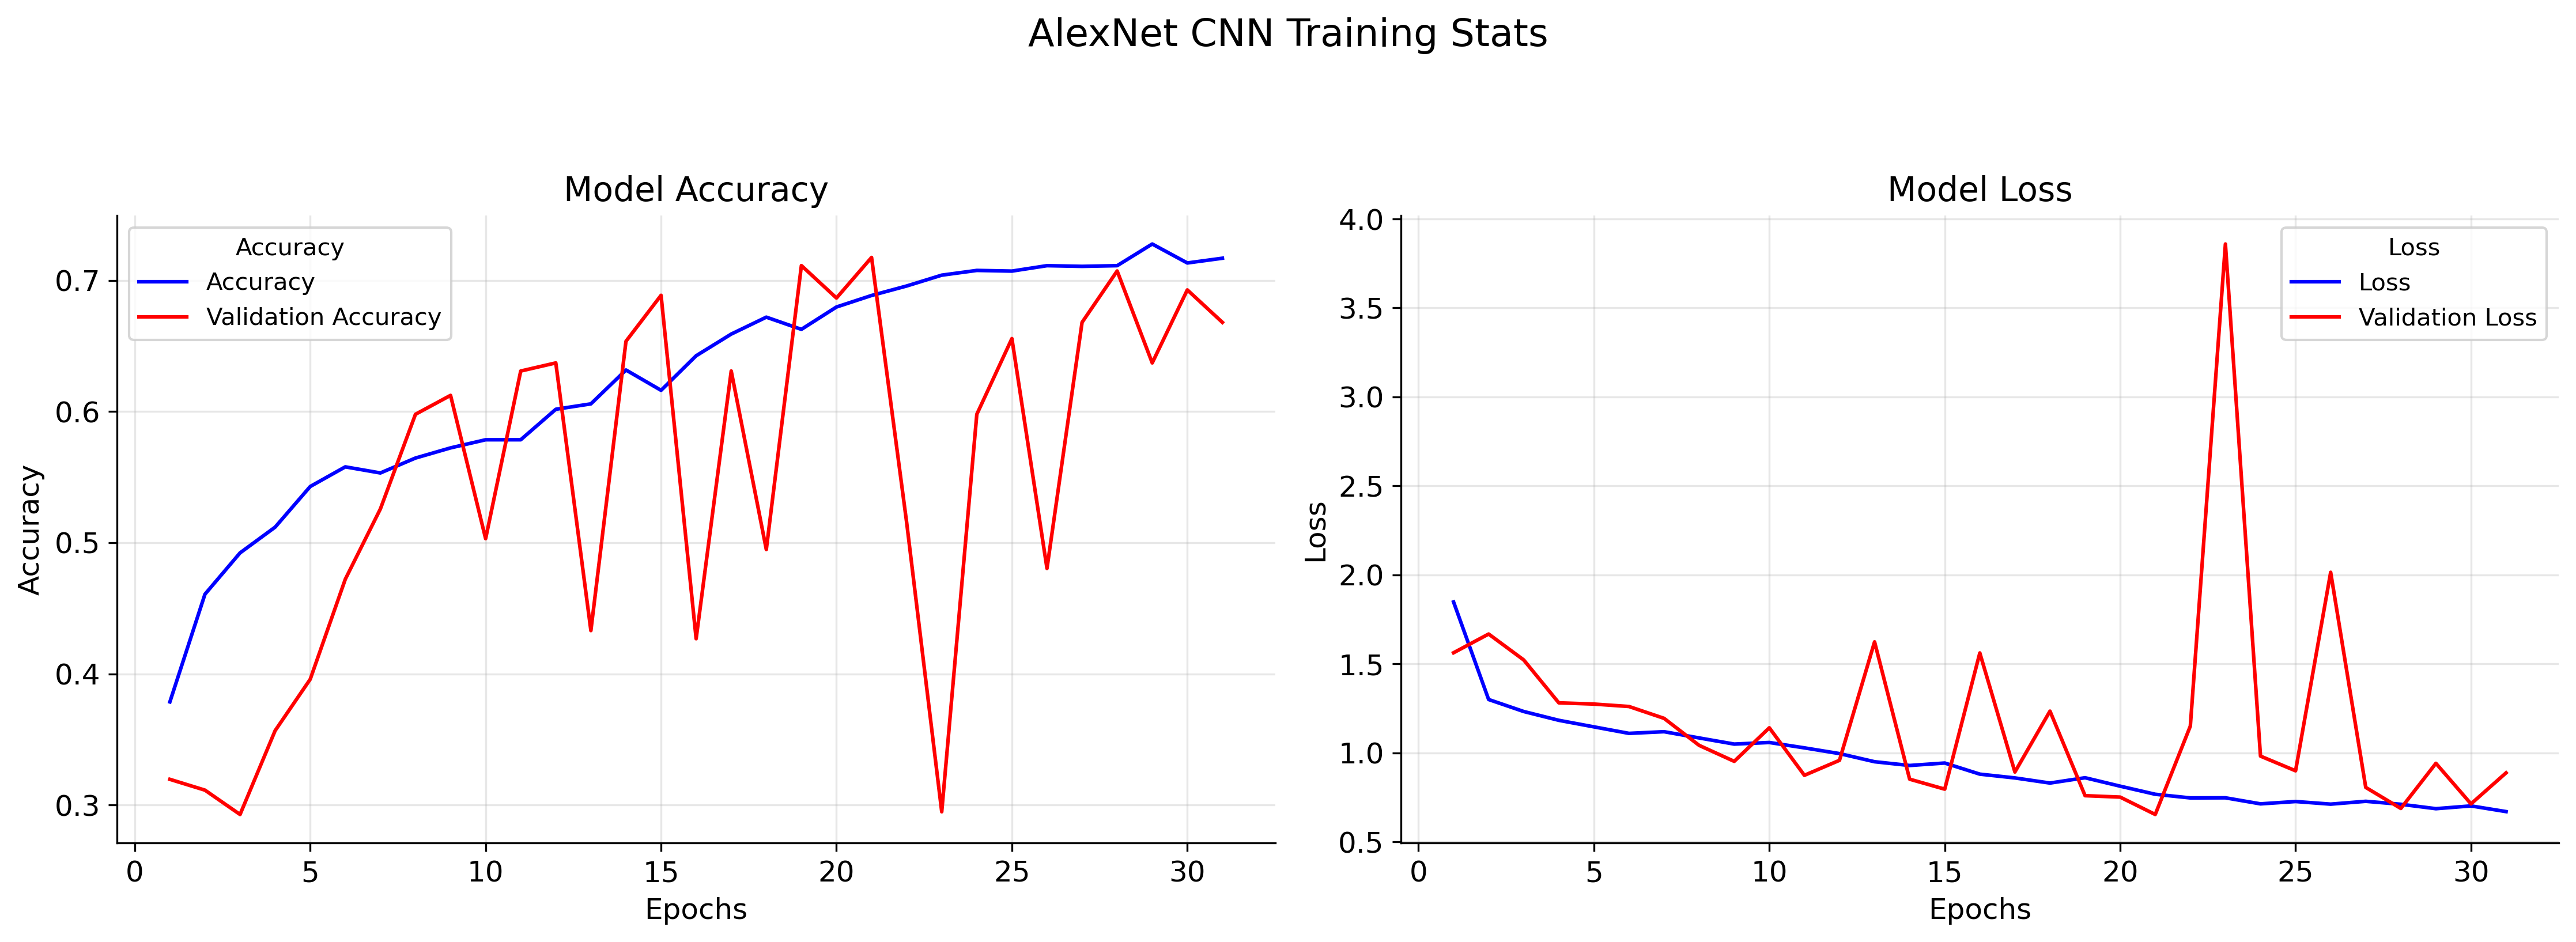

In [107]:
training_process_viz(pd.DataFrame(alexnet_train_history.history), plot_title = 'AlexNet CNN Training Stats')

61/61 [==============================] - 57s 937ms/step


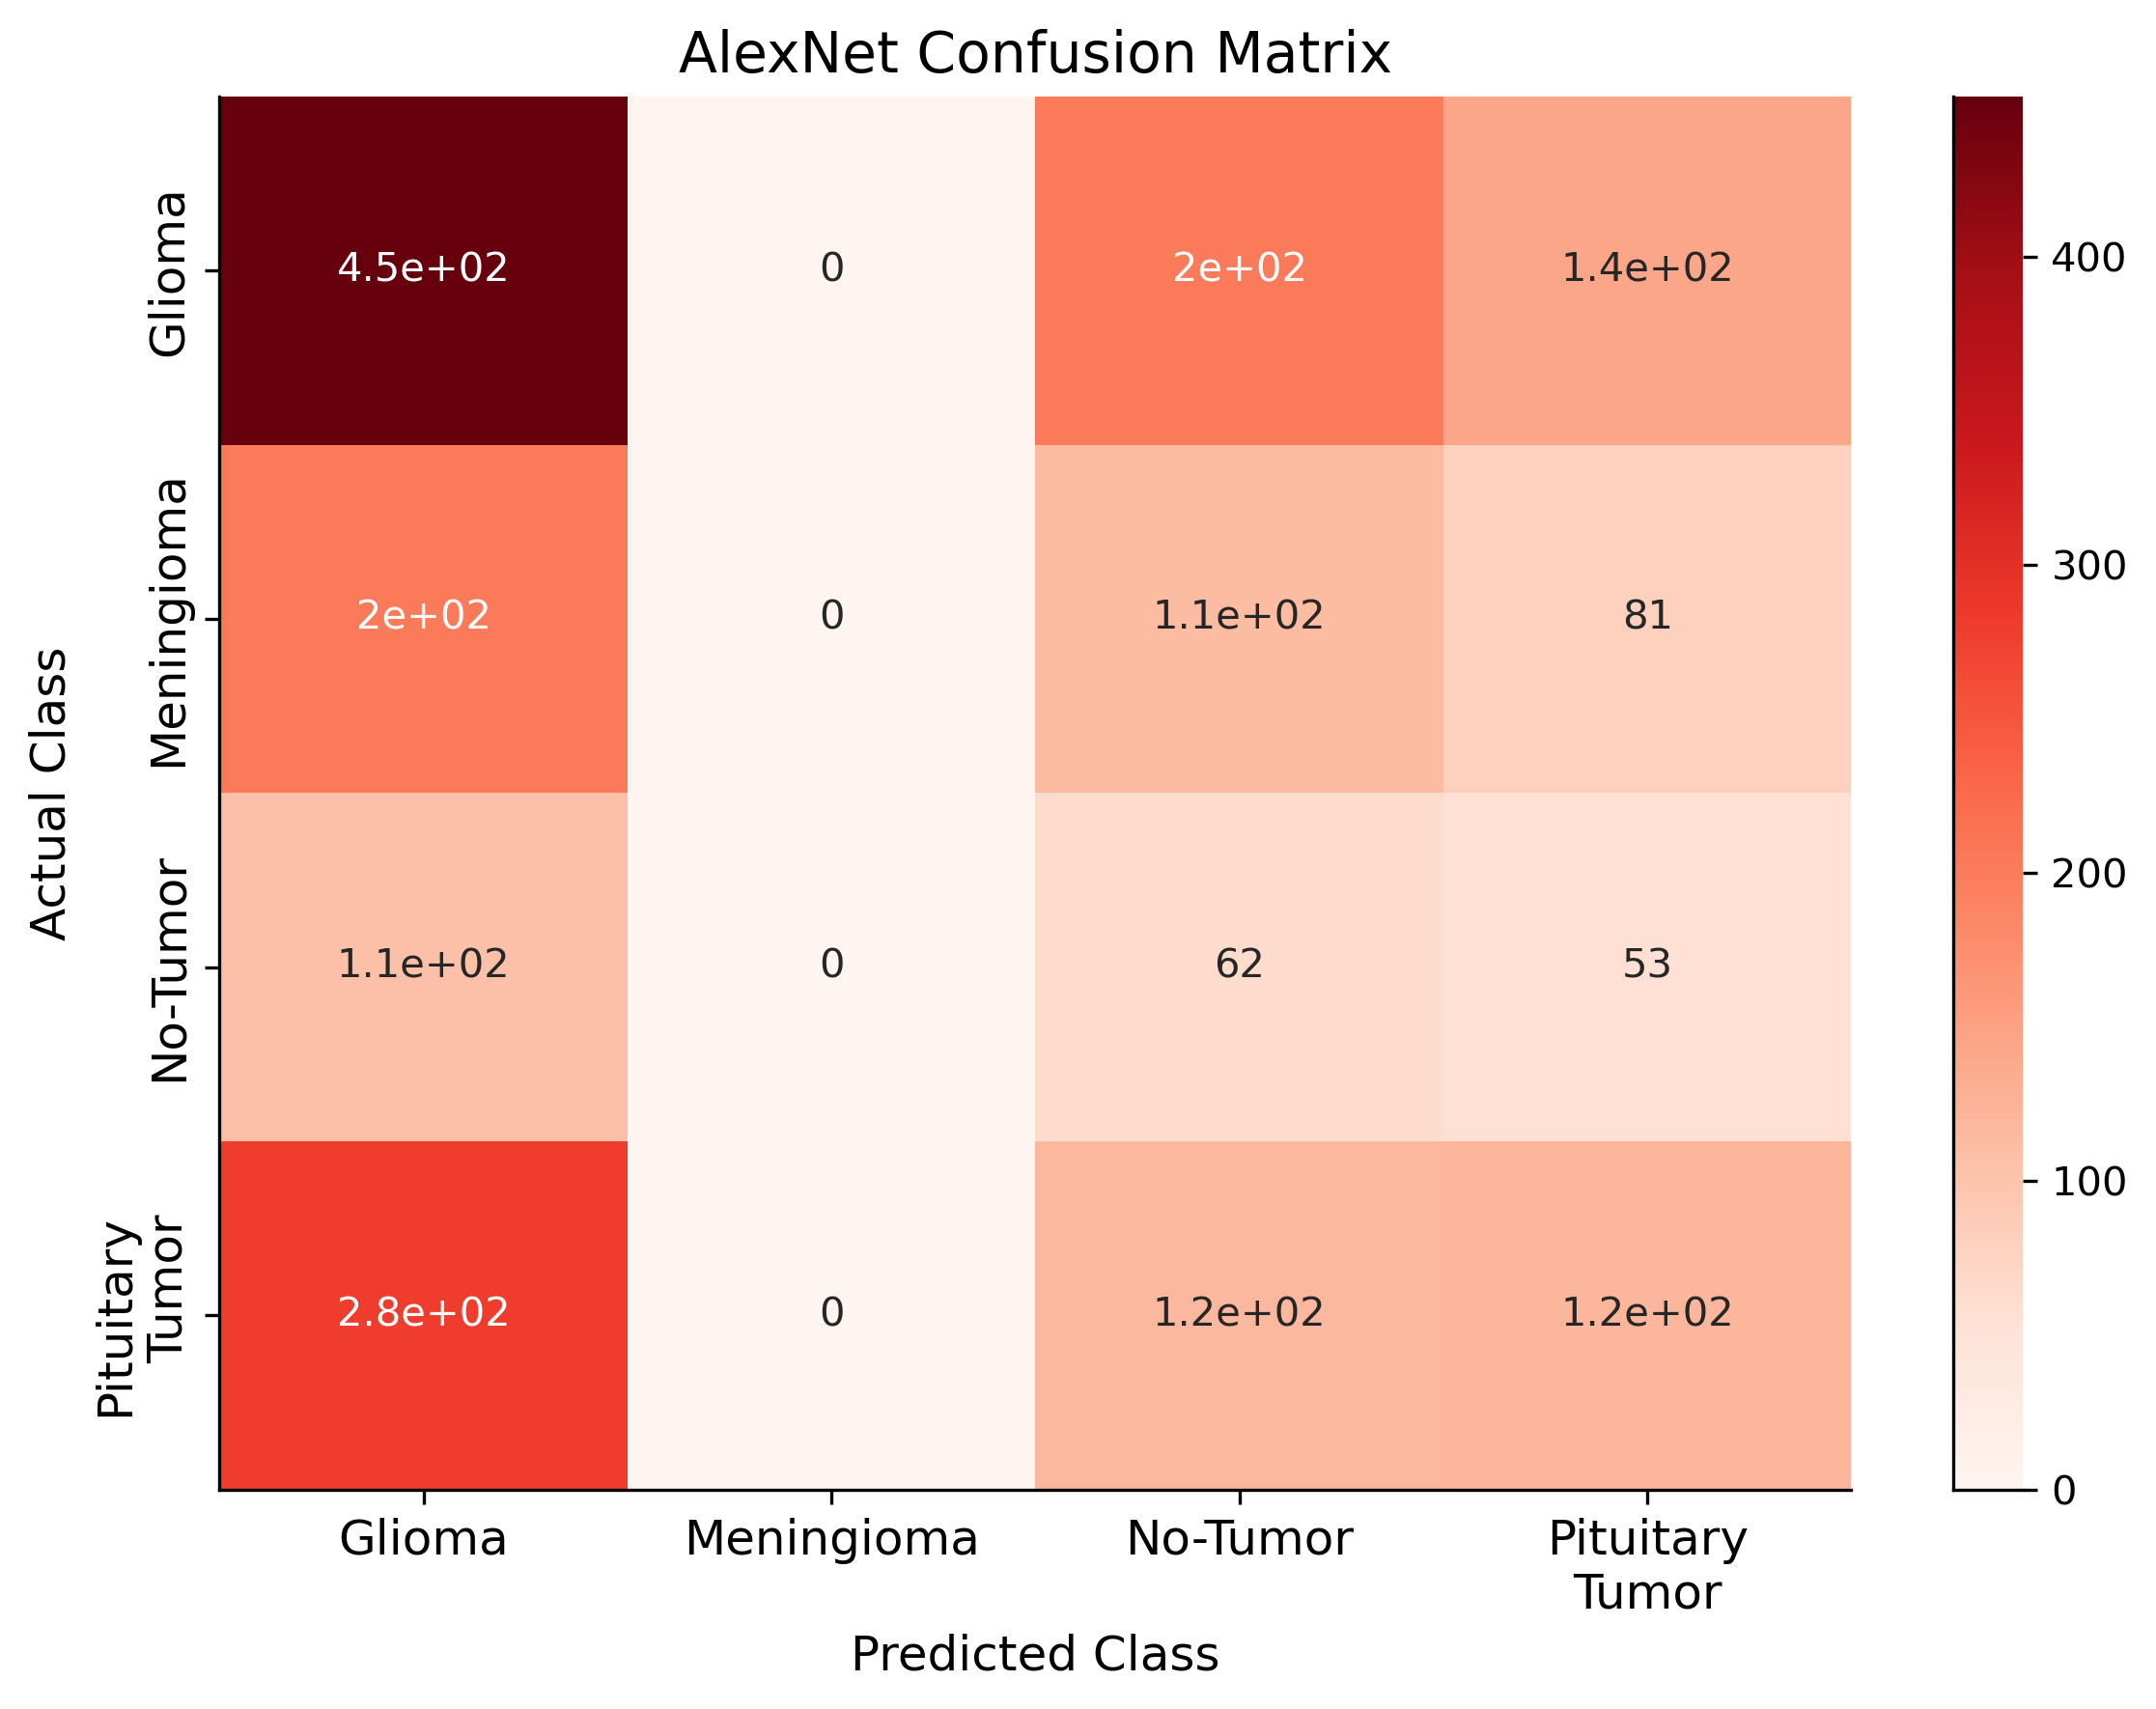

In [112]:
confusion_matrix_viz(alexnet_cnn, train_dataset, plot_title = "AlexNet Confusion Matrix")

In [113]:
alexnet_report_df = generate_report(alexnet_cnn, test_dataset = test_dataset, row_indexes = ['AlexNet CNN'])
alexnet_report_df

33/33 [==============================] - 31s 917ms/step


MAE       MSE      RMSE      Loss  Accuracy  F1-Score
AlexNet CNN  1.330443  3.047206  1.745625  0.887007  0.657033  0.313102

In [114]:
inception_v3_model = InceptionV3(include_top = False, 
                                 input_shape = (image_size, image_size, 3), 
                                 pooling = 'avg')
inception_v3_model.trainable = False

87910968/87910968 [==============================] - 58s 1us/step


In [115]:
inception_cnn_model = Sequential()
inception_cnn_model.add(inception_v3_model)
inception_cnn_model.add(Flatten())
inception_cnn_model.add(Dense(1024, activation = 'relu', name = 'Hidden-Layer-1'))
inception_cnn_model.add(Dense(4, activation = 'softmax', name = 'Output-Layer'))
inception_cnn_model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
inception_cnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 Hidden-Layer-1 (Dense)      (None, 1024)              2098176   
                                                                 
 Output-Layer (Dense)        (None, 4)                 4100      
                                                                 
Total params: 23,905,060
Trainable params: 2,102,276
Non-trainable params: 21,802,784
_________________________________________________________________


In [117]:
with tf.device(gpu_device_location) if gpu_device_location else tpu_strategy.scope() if tpu_device_location else tf.device(cpu_device_location):
    inception_model_train_history = inception_cnn_model.fit(train_dataset, 
                                                            batch_size = batch_size,
                                                            validation_data = validation_dataset, 
                                                            epochs = 100, 
                                                            callbacks = [early_stopping, inceptionv3_cp_callback])

Epoch 1/100
61/61 [==============================] - ETA: 0s - loss: 2.1218 - accuracy: 0.5718
Epoch 1: saving model to C:/USERS/HP/BRAIN-MRI-IMAGE-CLASSIFICATION-USING-DEEP-LEARNING\Model-Checkpoints\InceptionV3
61/61 [==============================] - 87s 1s/step - loss: 2.1218 - accuracy: 0.5718 - val_loss: 0.7589 - val_accuracy: 0.6866
Epoch 2/100
61/61 [==============================] - ETA: 0s - loss: 0.6669 - accuracy: 0.7355
Epoch 2: saving model to C:/USERS/HP/BRAIN-MRI-IMAGE-CLASSIFICATION-USING-DEEP-LEARNING\Model-Checkpoints\InceptionV3
61/61 [==============================] - 79s 1s/step - loss: 0.6669 - accuracy: 0.7355 - val_loss: 0.6279 - val_accuracy: 0.7608
Epoch 3/100
61/61 [==============================] - ETA: 0s - loss: 0.5710 - accuracy: 0.7779
Epoch 3: saving model to C:/USERS/HP/BRAIN-MRI-IMAGE-CLASSIFICATION-USING-DEEP-LEARNING\Model-Checkpoints\InceptionV3
61/61 [==============================] - 82s 1s/step - loss: 0.5710 - accuracy: 0.7779 - val_loss: 0.61

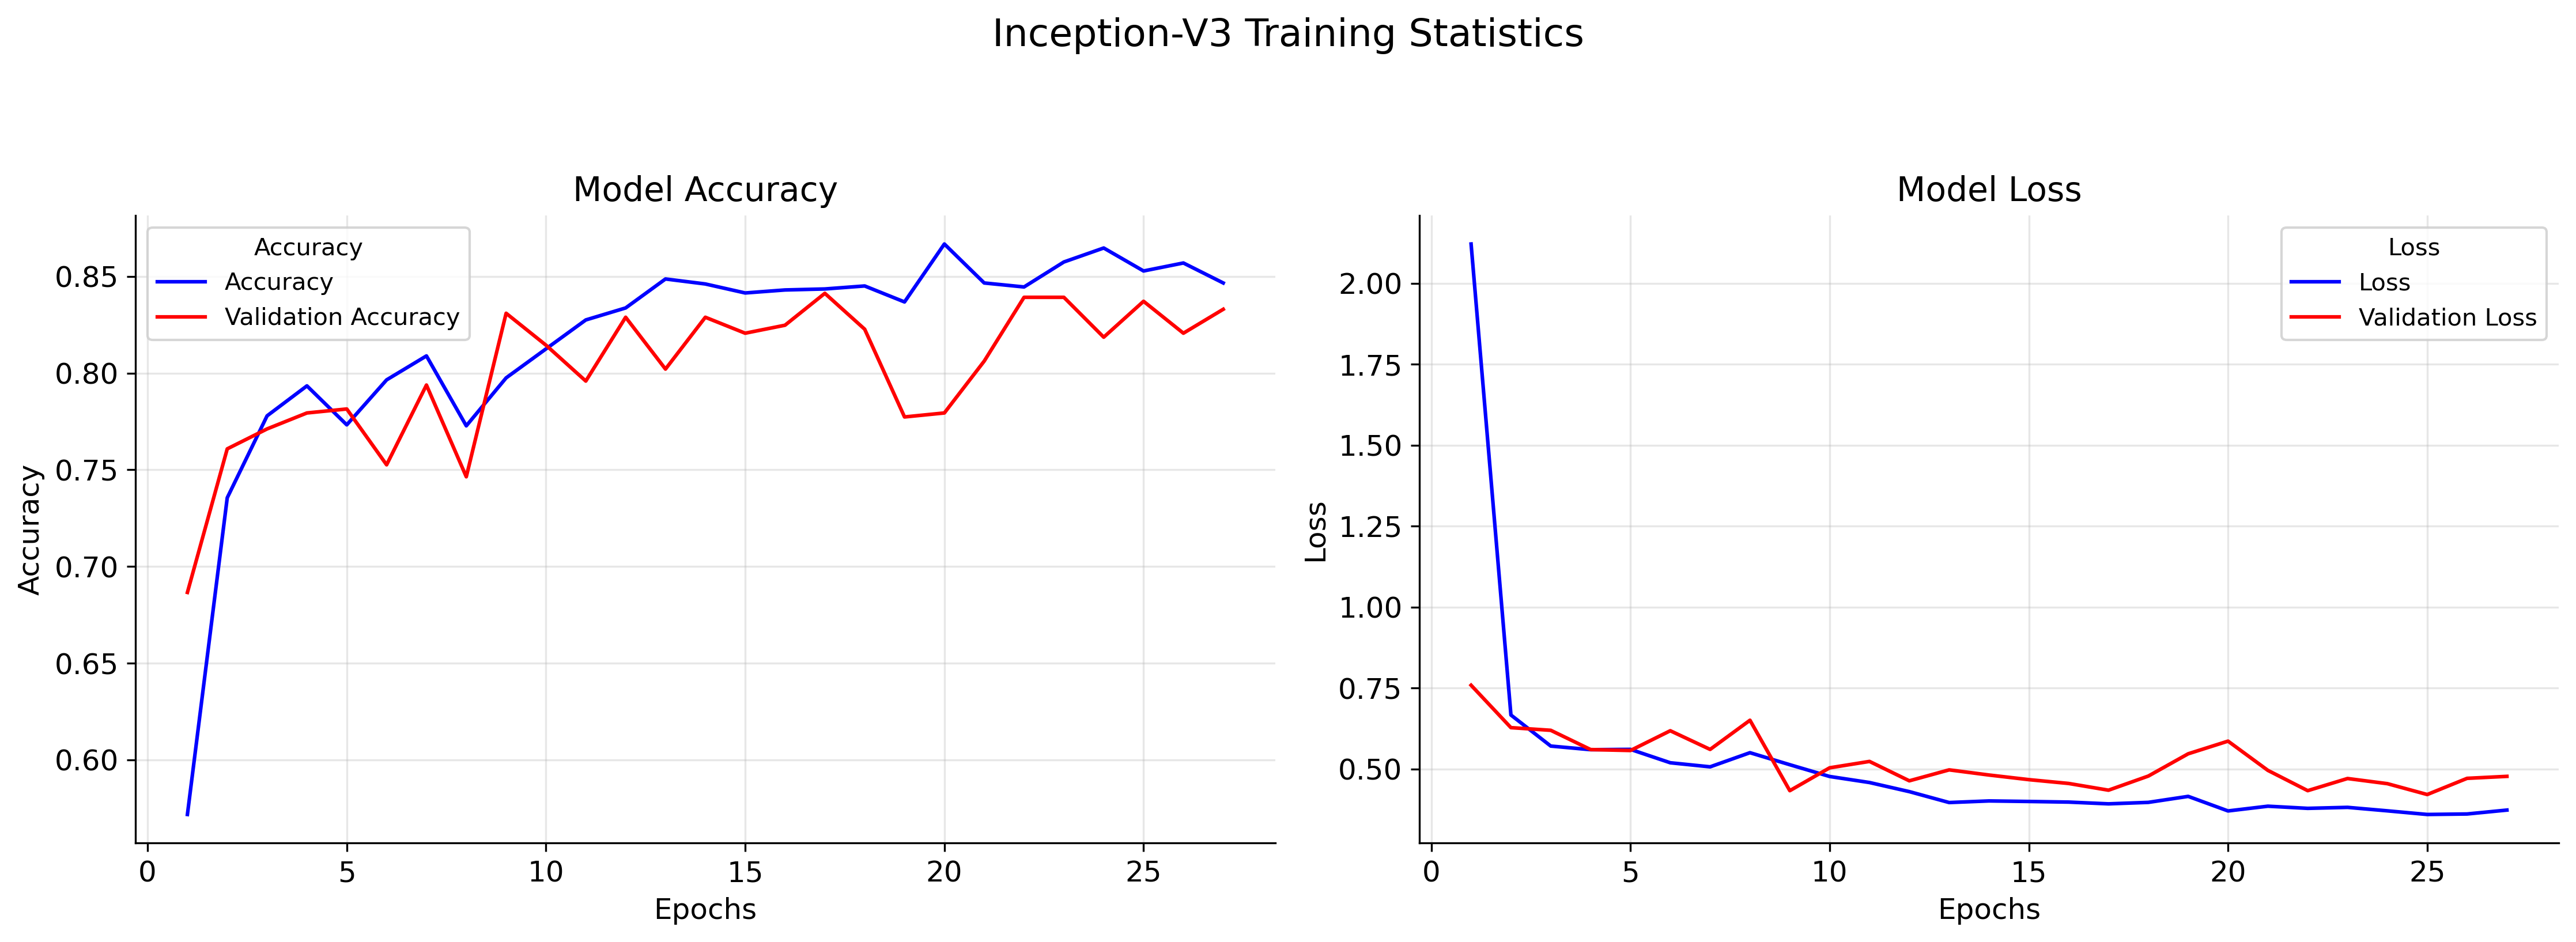

In [118]:
training_process_viz(pd.DataFrame(inception_model_train_history.history), 
                     plot_title = 'Inception-V3 Training Statistics')

61/61 [==============================] - 62s 989ms/step


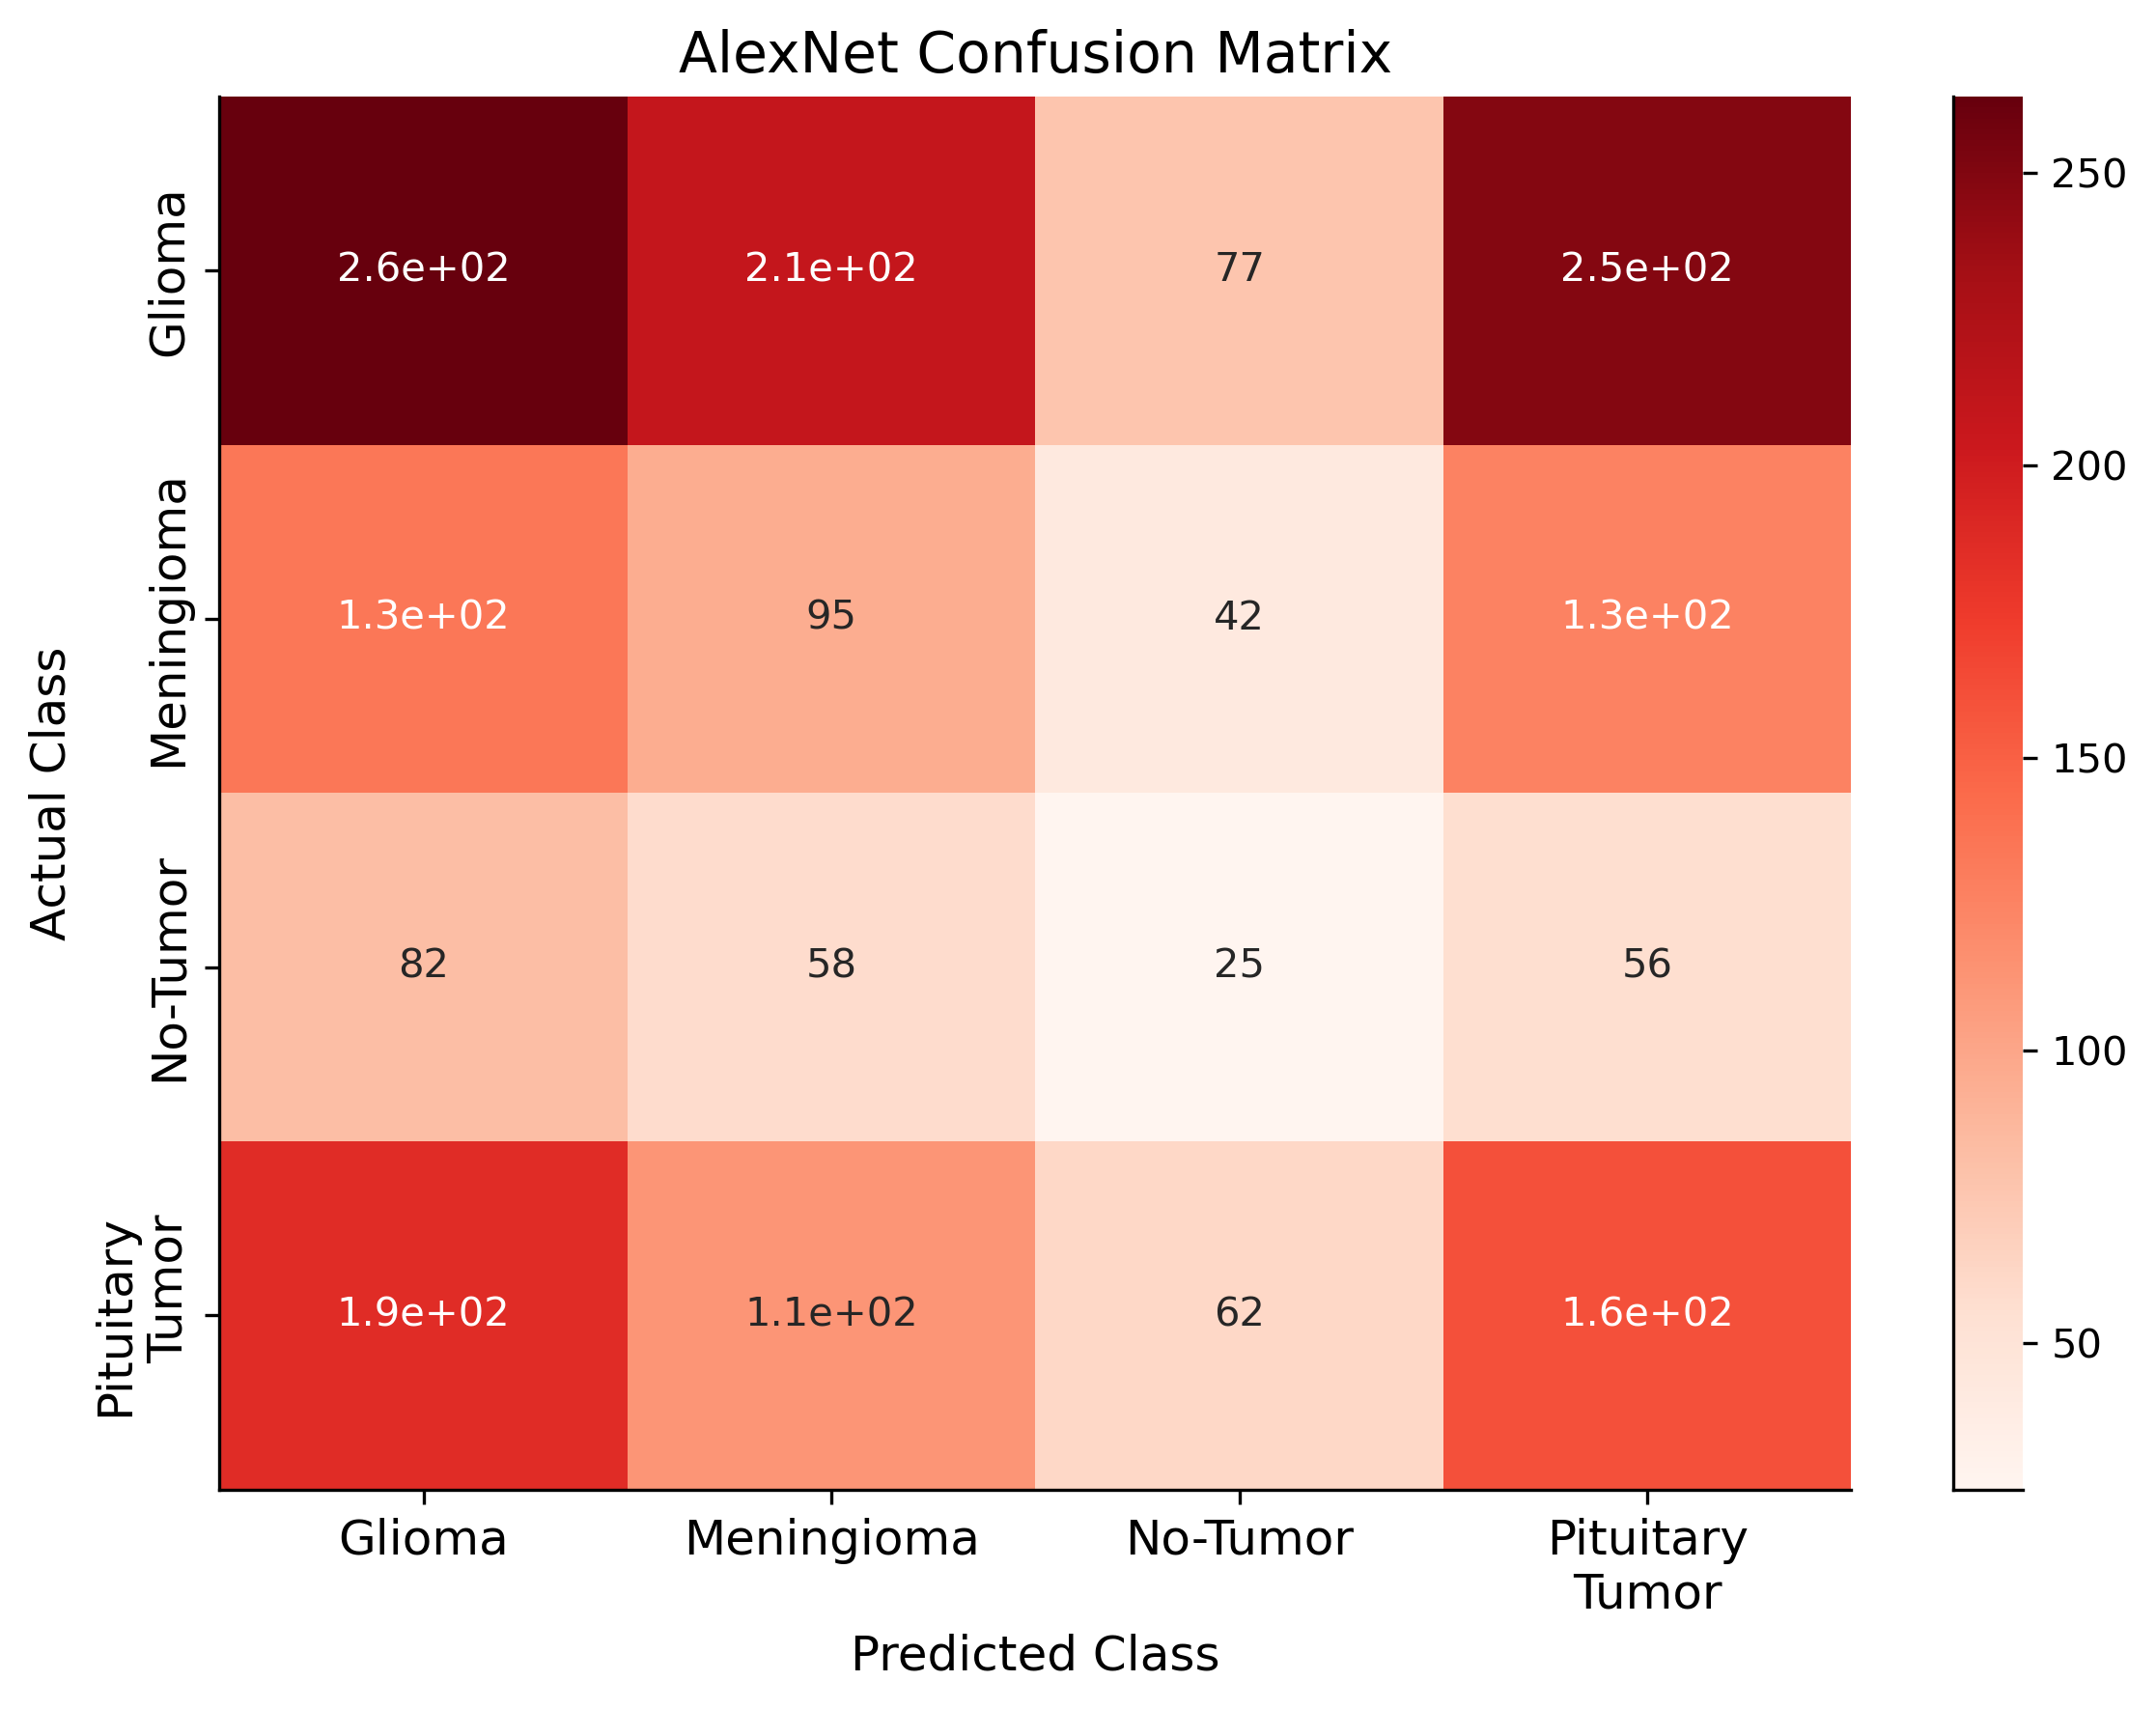

In [120]:
confusion_matrix_viz(inception_cnn_model, train_dataset, plot_title = "Inception V3 Confusion Matrix")

In [121]:
inceptionv3_report_df = generate_report(inception_cnn_model, test_dataset = test_dataset, row_indexes = ['InceptionV3'])
inceptionv3_report_df

33/33 [==============================] - 32s 953ms/step


MAE       MSE      RMSE      Loss  Accuracy  F1-Score
InceptionV3  1.345857  3.060694  1.749484  0.493676  0.815992  0.299615

In [122]:
final_report_df = pd.concat([mlp_report_df, alexnet_report_df, inceptionv3_report_df])
final_report_df

MAE       MSE      RMSE      Loss  \
Multi-Layer-Perceptron Model  1.461464  3.671484  1.916112  0.981677   
AlexNet CNN                   1.330443  3.047206  1.745625  0.887007   
InceptionV3                   1.345857  3.060694  1.749484  0.493676   

                              Accuracy  F1-Score  
Multi-Layer-Perceptron Model  0.587669  0.329480  
AlexNet CNN                   0.657033  0.313102  
InceptionV3                   0.815992  0.299615